## Splinter Session #1- Rasters, PSTHs, and dPCA Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from pathlib import Path
import pandas as pd
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
from scipy.ndimage import gaussian_filter1d
from matplotlib.gridspec import GridSpec
from scipy.stats import gamma
from scipy.signal import convolve2d
from scipy.optimize import minimize
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from elephant.gpfa import GPFA
import neo
import quantities as pq
from einops import rearrange
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import glob

In [96]:
# base_dir = r'/Users/srinidhienaidu/Downloads/GitHub/Paton-Lab--Summer-2024/Splinter' # Srinidhi Mac dir
# sorted(os.listdir(base_dir))
pooled_sessions = False 
session_num = 11
root_dir = r'/Users/srinidhienaidu/Downloads/GitHub/Paton-Lab--Summer-2024/Splinter'  # Replace with your "splinter" folder path
times = [0, 600, 1050, 1260, 1380, 1620, 1740, 1950, 2400]

if pooled_sessions == True:
    combined_log_df = pd.DataFrame()
    combined_session_df = pd.DataFrame()
    all_spike_times = []

    for subdir, dirs, files in sorted(os.walk(root_dir)):
        log_files = glob.glob(os.path.join(subdir, "LogDf.csv"))
        session_files = glob.glob(os.path.join(subdir, "SessionDf.csv"))
        spike_files = glob.glob(os.path.join(subdir, "spiketimes.npy"))

        for log_file in log_files:
            df_log = pd.read_csv(log_file)
            df_log['session'] = os.path.basename(subdir)
            combined_log_df = pd.concat([combined_log_df, df_log], ignore_index=True)
        
        for session_file in session_files:
            df_session = pd.read_csv(session_file)
            df_session['session'] = os.path.basename(subdir)
            combined_session_df = pd.concat([combined_session_df, df_session], ignore_index=True)

        for spike_file in spike_files:
            spike_times = np.load(spike_file, allow_pickle=True)
            session_name = os.path.basename(subdir)
            all_spike_times.append(spike_times)

    
    stacked_spike_times = np.hstack(all_spike_times)
    NUM_SESSIONS = len(os.listdir(root_dir)) - 1
    log_df = combined_log_df
    session_df = combined_session_df
    spike_times = stacked_spike_times
    print('Pooled Sessions = True')


elif pooled_sessions == False:
    print('Pooled Sessions = False')
    # root_dir = r'C:\Users\srini\Documents\GitHub\Paton-Lab--Summer-2024\Splinter' # Champalimaud PC dir

    root_dir = r'/Users/srinidhienaidu/Downloads/GitHub/Paton-Lab--Summer-2024/Splinter' # Srinidhi Mac dir
    session = session_num # Change based on which trial you want
    date = sorted(os.listdir(root_dir))[session + 1]
    path = os.path.join(root_dir, date)
    os.chdir(path)
    print(path)

    log_df = pd.read_csv('LogDf.csv')
    session_df = pd.read_csv('SessionDf.csv')

    log_data = log_df.to_dict(orient= 'dict')
    session_data = session_df.to_dict(orient= 'dict')

    spike_times = np.load('spiketimes.npy', allow_pickle=True)
    NUM_NEURONS = spike_times.shape[0]
    NUM_STIMS = 8

Pooled Sessions = False
/Users/srinidhienaidu/Downloads/GitHub/Paton-Lab--Summer-2024/Splinter/2016-08-12


In [97]:
log_data = log_df.to_dict(orient= 'dict')
session_data = session_df.to_dict(orient= 'dict')
NUM_NEURONS = spike_times.shape[0]
NUM_STIMS = 8

print('Number Neurons: ', NUM_NEURONS)
print('Path: ', path)
# print('# of Sessions: ', NUM_SESSIONS)
print('Log Keys: ', log_data.keys())
print('Session Keys: ', session_data.keys())

Number Neurons:  15
Path:  /Users/srinidhienaidu/Downloads/GitHub/Paton-Lab--Summer-2024/Splinter/2016-08-12
Log Keys:  dict_keys(['Unnamed: 0', 't', 'name', 'var', 'value'])
Session Keys:  dict_keys(['Unnamed: 0', 'chosen_side', 'chosen_interval', 'correct_side', 'interval_category', 'has_choice', 'this_interval', 'outcome', 'init_port', 'choice_rt', 't_on', 't_off', 't'])


In [98]:
def set_spines_invisible(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def set_grid_invisible(ax):
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

def common_label(fig, xlabel, ylabel):
    """Put a common `xlabel` and `ylabel` on the figure `fig`.
    
    Args:
        - fig (plt.figure)
        - xlabel (str)
        - ylabel (str)
    """
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [99]:
# Removes Nan Variables
def remove_nans(arr):
    return [x for x in arr if not math.isnan(x)]

# Returns indices of Nans
def nan_idx(data):
    nan_idx = []
    for index in data:
        if isinstance(data[index], float):
            nan_idx.append(index)
    return nan_idx

# Sorts a given "og_list" to a given array "list_to_sort_by" (usually used to reorder)
def list_to_sorted_arr(og_list, list_to_sort_by):
    arr = np.array(og_list)
    return arr[list_to_sort_by]

for cell in np.arange(NUM_NEURONS):
    spike_times[cell] = remove_nans(spike_times[cell])  

In [100]:
# Parsing through log_data file to save the stimulus onset and offset times
stim_onset_t_pre = []
stim_offset_t = []
reward_t = []
for index in np.arange(len(log_data['t'])):

    time = log_data['t'][index]
    name = log_data['name'][index]

    if name == 'STIM_ONSET_EVENT':
        stim_onset_t_pre.append(time)
    elif name == 'STIM_OFFSET_EVENT':
        stim_offset_t.append(time)
    elif name == 'REWARD_EVENT':
        reward_t.append(time)

if reward_t[-1] > stim_offset_t[-1]:
    reward_t = reward_t[:-1]

NUM_TRIALS = len(stim_offset_t)
trial_num = np.arange(0, len(stim_onset_t_pre), 1)

In [101]:
correct_choice = []
incorrect_choice = []
broken_choice = []

for index in np.arange(len(session_data['t'])):
    
    outcome = session_data['outcome'][index]
    # print(index, outcome)
    if outcome == "incorrect":
        incorrect_choice.append(index)
    elif outcome == 'correct':
        correct_choice.append(index)
    elif outcome == 'broken':
        broken_choice.append(index)

print(correct_choice)

[4, 7, 8, 14, 16, 17, 18, 19, 20, 21, 26, 27, 29, 31, 32, 34, 35, 38, 39, 40, 41, 42, 43, 45, 46, 48, 49, 51, 54, 55, 59, 60, 62, 63, 64, 65, 66, 68, 76, 78, 79, 80, 82, 84, 85, 88, 92, 93, 97, 98, 100, 101, 103, 106, 108, 112, 115, 119, 120, 121, 122, 128, 131, 133, 134, 137, 138, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 153, 165, 166, 167, 168, 170, 173, 174, 177, 178, 179, 180, 185, 186, 188, 191, 192, 195, 196, 197, 200, 201, 202, 204, 206, 210, 212, 214, 215, 217, 219, 220, 224, 226, 230, 233, 236, 241, 242, 246, 247, 250, 252, 253, 255, 256, 257, 267, 269, 271, 274, 275, 276, 281, 283, 284, 286, 291, 293, 294, 295, 296, 299, 301, 302, 305, 306, 309, 310, 312, 314, 315, 317, 318, 321, 323, 329, 330, 331, 333, 336, 337, 341, 344, 345, 349, 351, 353, 354, 358, 359, 361, 363, 364, 366, 367, 369, 371, 373, 375, 378, 382, 385, 387, 390, 391, 392, 393, 396, 397]


code for plotting raw rasters, before sorting by stim_duration

In [102]:
# window = [-2000,4000]
# n_trials = len(stim_onset_t)
# neuron = 13
# all_spikes_neuron = []
# all_trial_nums = []
# for idx, trial in enumerate(original_indices):
#     # print(trial)
#     # print(stim_onset_t[trial])
#     aligned_spikes = np.array(spike_times[neuron]) - stim_onset_t[trial]
#     # print(aligned_spikes)
#     trial_index_spikes = np.intersect1d(np.where(aligned_spikes<window[1])[0],np.where(aligned_spikes>window[0])[0])
#     all_spikes_neuron.extend(aligned_spikes[trial_index_spikes])
#     n_spikes = len(trial_index_spikes)
#     all_trial_nums.extend([trial]*n_spikes)
# print(all_trial_nums)
# plt.figure()
# plt.scatter(all_spikes_neuron, all_trial_nums,s=0.1)
# plt.ylabel("Trial number")
# plt.xlabel("Time since stimulus onset (ms)")
# plt.title(f"Neuron {neuron}")
# plt.axvline(x=0,color="k",ls="--")
# plt.show()

### Preprocessing for correct trials

In [103]:
# Cleaning up the data, so that if the rat does not clock a choice the according trial onset and offset are discarded
choice = session_data['chosen_side']
outcome = session_data['outcome']

no_choice_idx = nan_idx(choice)

stim_onset_t = [value for index, value in enumerate(stim_onset_t_pre) if index not in no_choice_idx and index in correct_choice]
og_trial_num = [value for index, value in enumerate(trial_num) if index not in no_choice_idx and index in correct_choice]
trial_outcome = [value for index, value in enumerate(outcome) if index not in no_choice_idx and index in correct_choice]

general_trial_num = np.arange(0, len(stim_onset_t), 1)
int_durations = np.zeros((len(stim_onset_t)))
choice_rt = []
idx_to_remove = []

# The trial numbers are also reordered to take into account "dropped" trials 
for idx, val in enumerate(og_trial_num):
    try:
        int_durations[idx] = session_data['this_interval'][val]
        choice_rt.append(session_data['choice_rt'][val])
    except Exception as e:
        print(f"Skipping iteration {idx} due to error: {e} out of index")
        idx_to_remove.append(idx)
        continue

for index in sorted(idx_to_remove, reverse=True):
    int_durations = np.delete(int_durations, index)

# After getting the specific interval duration times, we are sorting so that the durations go from shortest (600) to longest (2400) duration values
sort_by_dur_idx = np.argsort(int_durations)
sorted_int_durations = int_durations[sort_by_dur_idx]
new_sorted_trials = general_trial_num[sort_by_dur_idx]
og_sorted_trials = list_to_sorted_arr(og_trial_num, sort_by_dur_idx)
sorted_choice_rt = list_to_sorted_arr(choice_rt, sort_by_dur_idx)

### Preprocessing for incorrect trials

In [104]:
# Cleaning up the data, so that if the rat does not clock a choice the according trial onset and offset are discarded
choice = session_data['chosen_side']
outcome = session_data['outcome']

no_choice_idx = nan_idx(choice)

# stim_onset_t = [value for index, value in enumerate(stim_onset_t_pre) if index not in no_choice_idx and index in correct_choice]
# og_trial_num = [value for index, value in enumerate(trial_num) if index not in no_choice_idx and index in correct_choice]
# trial_outcome = [value for index, value in enumerate(outcome) if index not in no_choice_idx and index in correct_choice]


IC_stim_onset_t = [value for index, value in enumerate(stim_onset_t_pre) if index not in no_choice_idx and index in incorrect_choice]
IC_og_trial_num = [value for index, value in enumerate(trial_num) if index not in no_choice_idx and index in incorrect_choice]
IC_trial_outcome = [value for index, value in enumerate(outcome) if index not in no_choice_idx and index in incorrect_choice]


IC_general_trial_num = np.arange(0, len(IC_stim_onset_t), 1)
IC_int_durations = np.zeros((len(IC_stim_onset_t)))
IC_choice_rt = []
IC_idx_to_remove = []

# The trial numbers are also reordered to take into account "dropped" trials 
for idx, val in enumerate(IC_og_trial_num):
    try:
        IC_int_durations[idx] = session_data['this_interval'][val]
        IC_choice_rt.append(session_data['choice_rt'][val])
    except Exception as e:
        print(f"Skipping iteration {idx} due to error: {e} out of index")
        IC_idx_to_remove.append(idx)
        continue

for index in sorted(IC_idx_to_remove, reverse=True):
    IC_int_durations = np.delete(IC_int_durations, index)

# After getting the specific interval duration times, we are sorting so that the durations go from shortest (600) to longest (2400) duration values
IC_sort_by_dur_idx = np.argsort(IC_int_durations)
IC_sorted_int_durations = IC_int_durations[IC_sort_by_dur_idx]
IC_new_sorted_trials = IC_general_trial_num[IC_sort_by_dur_idx]
IC_og_sorted_trials = list_to_sorted_arr(IC_og_trial_num, IC_sort_by_dur_idx)
IC_sorted_choice_rt = list_to_sorted_arr(IC_choice_rt, IC_sort_by_dur_idx)

In [105]:
NUM_TRIALS = int_durations.shape[0]
# NUM_IC_TRIALS = IC_int_durations.shape[0]

In [106]:
# Keeping track of trial indices for when the rat starts at the North or South ports
def idx_start_ports(new_sorted_trials, sorted_int_durations):
    n_sorted_init = []
    n_init_dur = []

    s_sorted_init = []
    s_init_dur = []
    n_rt = []
    s_rt = []

    init_port = session_data['init_port']

    for dur, val in enumerate(new_sorted_trials):
        if init_port[val] == 'N':
            n_sorted_init.append(val)
            n_init_dur.append(sorted_int_durations[dur])
            n_rt.append(reward_t[val])

        elif init_port[val] == 'S':
            s_sorted_init.append(val)
            s_init_dur.append(sorted_int_durations[dur])
            s_rt.append(reward_t[val])
    n_sorted_init = np.array(n_sorted_init)
    s_sorted_init = np.array(s_sorted_init)

    return n_sorted_init, s_sorted_init, n_init_dur, s_init_dur, n_rt, s_rt

In [107]:
n_sorted_init, s_sorted_init, n_init_dur, s_init_dur, n_rt, s_rt = idx_start_ports(new_sorted_trials= new_sorted_trials, sorted_int_durations= sorted_int_durations)
# IC_n_sorted_init, IC_s_sorted_init, IC_n_init_dur, IC_s_init_dur, IC_n_rt, IC_s_rt = idx_start_ports(new_sorted_trials= IC_new_sorted_trials, sorted_int_durations= IC_sorted_int_durations)

In [108]:
times

[0, 600, 1050, 1260, 1380, 1620, 1740, 1950, 2400]

In [109]:
# to_count = IC_n_init_dur

# int_counts = Counter(to_count)

# counts_values = list(int_counts.values())
# counts_keys = list(int_counts.keys())
# # times
# counts = np.zeros((NUM_STIMS))
# cumulative_sum_list = [0]

# for stim_time in range(NUM_STIMS):
#     time_val = times[stim_time + 1]
#     for idx, key in enumerate(counts_keys):
#         if key == time_val:
#             counts[stim_time] = int(counts_values[idx])
# running_total = 0
# for value in counts:
#     running_total += value
#     cumulative_sum_list.append(int(running_total))


In [110]:
# Deciding the colors to be used in the plots
def plot_colors(cmap):
    cmap = plt.get_cmap(cmap)
    points = np.linspace(0, 1, NUM_STIMS + 1)
    colors = []
    for stim in np.arange(NUM_STIMS):
        colors.append(cmap(points[stim + 1]))
    return colors

# Returns the individual counts (per stim-duration time) and cumulative sum of the given "to_count" array
def counts_and_cumulative(to_count):
    int_counts = Counter(to_count)

    counts_values = list(int_counts.values())
    counts_keys = list(int_counts.keys())
    # times
    counts = np.zeros((NUM_STIMS))
    cumulative_sum_list = [0]

    for stim_time in range(NUM_STIMS):
        time_val = times[stim_time + 1]
        for idx, key in enumerate(counts_keys):
            if key == time_val:
                counts[stim_time] = int(counts_values[idx])
    # counts = int(counts)
    counts = list(counts)
    counts_int = []
    running_total = 0
    for value in counts:
        counts_int.append(int(value))
        running_total += value
        cumulative_sum_list.append(int(running_total))

    return counts_int, cumulative_sum_list

def bin_values_by_range(values, start_values, end_values):
    bins = []
    for start, end in zip(start_values, end_values):
        mask = (values >= start) & (values < end)
        bins.append(len(values[mask]))
        bin_array = np.array(bins)

    return bin_array

In [111]:
counts, cumulative_sum_list = counts_and_cumulative(sorted_int_durations)
n_counts, n_cumulative_sum = counts_and_cumulative(n_init_dur)
s_counts, s_cumulative_sum = counts_and_cumulative(s_init_dur)

In [112]:
# IC_counts, IC_cumulative_sum_list = counts_and_cumulative(IC_sorted_int_durations)
# IC_n_counts, IC_n_cumulative_sum = counts_and_cumulative(IC_n_init_dur)
# IC_s_counts, IC_s_cumulative_sum = counts_and_cumulative(IC_s_init_dur)

In [113]:
reward_times_onset_aligned = list_to_sorted_arr(reward_t, sort_by_dur_idx) - list_to_sorted_arr(stim_onset_t, sort_by_dur_idx)

In [114]:
#  Function to average across trials within the same stim-duration type, as by the given cumulative sums list, and given stacked bin array
# Returns the average firing rate over all trials in a stimulus duration
def sum_over_trial_bins(stacked_bin_array, cumulative_sum_list):
    for_trial_sums = []
    raw_bins = []
    for stim_dur in np.arange(NUM_STIMS):
        bin_start = cumulative_sum_list[stim_dur]
        bin_end = cumulative_sum_list[stim_dur + 1] 
        summed_counts = (stacked_bin_array[:][bin_start:bin_end])
        raw_bins.append(summed_counts)
        normalized_counts = summed_counts / BIN_SIZE * 1000
        mean_counts = np.mean(normalized_counts, axis = 0)
        for_trial_sums.append(mean_counts)

    sum_over_trial_bins = np.vstack(for_trial_sums)
    raw_bin_arr = np.vstack(raw_bins)
    return raw_bin_arr, sum_over_trial_bins

# Realigns the data to the given data (usually onset or offset), and also plots the given data_points as emphasized (usually the start of behavior)
def rasters_and_psths(color, data, data_points, num_neurons, window, BIN_SIZE, new_sorted_trials, cumulative_sum_list):
    COND_NUM_TRIALS = len(new_sorted_trials)
    
    psth_colors = plot_colors(cmap = color)
    cmap = plt.get_cmap(color)
    norm = mcolors.Normalize(vmin=600, vmax=2400)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    full_spikes_neuron = []
    full_trial_nums = []
    full_summed_over_bins = []
    full_raw_bins = []
    full_cond_spike_times = []

    for neuron in np.arange(num_neurons):
        bins = np.arange(window[0], window[1], BIN_SIZE)
        all_spikes_neuron = []
        all_trial_nums = []
        binned_counts_array = []
        for_cond_spike_times = []
        # Initializing the emphasized data points that will be plotted for each trial
        colored_time_points = np.array(list_to_sorted_arr(stim_offset_t, sort_by_dur_idx) + list_to_sorted_arr(data_points, sort_by_dur_idx) - list_to_sorted_arr(data, sort_by_dur_idx))

        for num, val in enumerate(new_sorted_trials):
            # For Rasters
            aligned_spikes = np.array(spike_times[neuron]) - data[val]
            trial_index_spikes = np.intersect1d(np.where(aligned_spikes <= window[1])[0], np.where(aligned_spikes > window[0])[0])
            spike_times_in_window = aligned_spikes[trial_index_spikes]
            all_spikes_neuron.extend(spike_times_in_window)
            n_spikes = len(trial_index_spikes)
            all_trial_nums.extend([num] * n_spikes)

            # For PSTHs
            binned_counts = bin_values_by_range(values= spike_times_in_window, start_values= bins, end_values= bins + BIN_SIZE)
            binned_counts_array.append(np.array(binned_counts))
            for_cond_spike_times.append(colored_time_points[num])

        full_spikes_neuron.append(all_spikes_neuron)
        full_trial_nums.append(all_trial_nums)

        stacked_bin_array = np.vstack(binned_counts_array)
        raw_bin, norm_sum_bins = sum_over_trial_bins(stacked_bin_array, cumulative_sum_list)
        full_raw_bins.append(stacked_bin_array)

        full_summed_over_bins.append(norm_sum_bins)
        full_cond_spike_times.append(for_cond_spike_times)
        
    return full_raw_bins, COND_NUM_TRIALS, psth_colors, full_spikes_neuron, full_trial_nums, full_summed_over_bins, full_cond_spike_times


In [115]:
# Initializing the organized data to be used throughout analysis- both north and south start times, aligned to the stimulus onset and offset
# Setting the parameters to be used for the rest of the raster and PSTH plots
BIN_SIZE = 10
window = [-1000, 8000]
bins = np.arange(window[0], window[1], BIN_SIZE) 
num_neurons = NUM_NEURONS

# Corresponding bin indices for the starts of all of the stimulus durations
times = [0, 600, 1050, 1260, 1380, 1620, 1740, 1950, 2400]
normal_time_idx = []
for time in times:
    index = np.where(bins == time)[0][0]
    normal_time_idx.append(index)

n_onset_raw_bins, N_NUM_TRIALS, n_onset_psth_colors, n_onset_spikes, n_onset_trials, n_onset_summed, n_onset_colored_points = rasters_and_psths(color= 'Reds', data= stim_onset_t, data_points= choice_rt, num_neurons= NUM_NEURONS, window= window, BIN_SIZE= BIN_SIZE, new_sorted_trials= n_sorted_init, cumulative_sum_list=n_cumulative_sum)
print('N ONSET COMPLETE')
n_offset_raw_bins, N_NUM_TRIALS, n_offset_psth_colors, n_offset_spikes, n_offset_trials, n_offset_summed, n_offset_colored_points = rasters_and_psths(color= 'Reds', data= stim_offset_t, data_points= choice_rt, num_neurons= NUM_NEURONS, window= window, BIN_SIZE= BIN_SIZE, new_sorted_trials= n_sorted_init, cumulative_sum_list= n_cumulative_sum)
print('N OFFSET COMPLETE')
s_onset_raw_bins, S_NUM_TRIALS, s_onset_psth_colors, s_onset_spikes, s_onset_trials, s_onset_summed, s_onset_colored_points = rasters_and_psths(color= 'Blues', data= stim_onset_t, data_points= choice_rt, num_neurons= NUM_NEURONS, window= window, BIN_SIZE= BIN_SIZE, new_sorted_trials= s_sorted_init, cumulative_sum_list= s_cumulative_sum)
print('S ONSET COMPLETE')
s_offset_raw_bins, S_NUM_TRIALS, s_offset_psth_colors, s_offset_spikes, s_offset_trials, s_offset_summed, s_offset_colored_points = rasters_and_psths(color= 'Blues', data= stim_offset_t, data_points= choice_rt, num_neurons= NUM_NEURONS, window= window, BIN_SIZE= BIN_SIZE, new_sorted_trials= s_sorted_init, cumulative_sum_list= s_cumulative_sum)
print('S OFFSET COMPLETE')
c_onset_raw_bins, C_NUM_TRIALS, c_onset_psth_colors, c_onset_spikes, c_onset_trials, c_onset_summed, c_onset_colored_points = rasters_and_psths(color= 'Purples', data= stim_onset_t, data_points= choice_rt, num_neurons= NUM_NEURONS, window= window, BIN_SIZE= BIN_SIZE, new_sorted_trials= new_sorted_trials, cumulative_sum_list= cumulative_sum_list)
print('C ONSET COMPLETE')

KeyboardInterrupt: 

In [ ]:
# Plotting all of the raster and unfiltered PSTH plots for every combination, across all neurons
cmap1 = plt.get_cmap('Reds')
norm1 = mcolors.Normalize(vmin=600, vmax=2400)
sm1 = plt.cm.ScalarMappable(cmap=cmap1, norm=norm1)
sm1.set_array([])

cmap2 = plt.get_cmap('Blues')
norm2 = mcolors.Normalize(vmin=0, vmax=100)  
sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])

for neuron in np.arange(num_neurons):
    fig, axs = plt.subplots(4, 2, figsize=(16, 12))
    fig.subplots_adjust(left=0.25, right=0.9, top=0.9, bottom=0.1, hspace=0.4, wspace=0.4)

    cbar_ax1 = fig.add_axes([0.1, 0.1, 0.02, 0.8])
    cbar1 = plt.colorbar(sm1, cax=cbar_ax1, orientation='vertical')
    cbar1.ax.invert_yaxis()
    cbar1.ax.set_yticks([])

    cbar_ax2 = fig.add_axes([0.15, 0.1, 0.02, 0.8]) 
    cbar2 = plt.colorbar(sm2, cax=cbar_ax2, orientation='vertical')
    cbar2.set_label('Trial #')
    cbar2.ax.invert_yaxis()

    # North Rasters- Onset
    axs[0, 0].scatter(n_onset_spikes[neuron], n_onset_trials[neuron], s = 0.01, color = 'k')
    axs[0, 0].scatter(n_onset_colored_points[neuron], range(N_NUM_TRIALS), s = 0.3, color = 'r') # type: ignore
    axs[0, 0].set_ylabel("Trial #") # type: ignore
    axs[0, 0].set_title(f"Aligned to Stimulus Onset")
    axs[0, 0].axvline(x=0, color="k", ls="--")
    axs[0, 0].set_xlim(window[0], window[1])  

    # North Rasters- Offset
    axs[0, 1].scatter(n_offset_spikes[neuron], n_offset_trials[neuron], s = 0.01, color = 'k')
    axs[0, 1].scatter(n_offset_colored_points[neuron], range(N_NUM_TRIALS), s = 0.3, color = 'r')
    axs[0, 1].set_title(f"Aligned to Stimulus Offset")
    axs[0, 1].axvline(x=0, color="k", ls="--")
    axs[0, 1].set_xlim(window[0], window[1])

    # South Rasters- Onset
    axs[1, 0].scatter(s_onset_spikes[neuron], s_onset_trials[neuron], s = 0.01, color = 'k')
    axs[1, 0].scatter(s_onset_colored_points[neuron], range(S_NUM_TRIALS), s = 0.3, color = 'b')
    axs[1, 0].set_ylabel("Trial #")
    axs[1, 0].axvline(x=0, color="k", ls="--")
    axs[1, 0].set_xlim(window[0], window[1])  

    # South Rasters- Offset
    axs[1, 1].scatter(s_offset_spikes[neuron], s_offset_trials[neuron], s = 0.01, color = 'k')
    axs[1, 1].scatter(s_offset_colored_points[neuron], range(S_NUM_TRIALS), s = 0.3, color = 'b')
    axs[1, 1].axvline(x=0, color="k", ls="--")
    axs[1, 1].set_xlim(window[0], window[1])

    for stim in np.arange(NUM_STIMS):

        # North PSTHs- Onset
        axs[2, 0].plot(bins, n_onset_summed[neuron][stim], color = n_onset_psth_colors[stim], linewidth = 0.9)
        axs[2, 0].axvline(x=0, color="k", ls="--")
        axs[2, 0].set_xlim(window[0], window[1])
        axs[2, 0].set_ylabel('Firing Rate (Hz)')


        # North PSTHs- Offset
        axs[2, 1].plot(bins, n_offset_summed[neuron][stim], color = n_offset_psth_colors[stim], linewidth = 0.9)
        axs[2, 1].axvline(x=0, color="k", ls="--")
        axs[2, 1].set_xlim(window[0], window[1])

        # South PSTHs- Onset
        axs[3, 0].plot(bins, s_onset_summed[neuron][stim], color = s_onset_psth_colors[stim], linewidth = 0.9)
        axs[3, 0].axvline(x=0, color="k", ls="--")
        axs[3, 0].set_xlim(window[0], window[1])
        axs[3, 0].set_ylabel('Firing Rate (Hz)')
        # South PSTHs- Offset
        axs[3, 1].plot(bins, s_offset_summed[neuron][stim], color = s_offset_psth_colors[stim], linewidth = 0.9)
        axs[3, 1].axvline(x=0, color="k", ls="--")
        axs[3, 1].set_xlim(window[0], window[1])

    fig.suptitle(f'Neuron {neuron}', fontsize = 25)

In [ ]:
reshaped_bins = []
for neuron in np.arange(NUM_NEURONS):
    og_binned_counts = s_onset_summed[neuron]
    len_spike_train = s_onset_summed[neuron].shape[0] * s_onset_summed[neuron].shape[1]
    reshaped_bins.append(np.reshape(og_binned_counts, (1, len_spike_train)))

X_data = np.vstack(reshaped_bins)
mean_vec = np.mean(X_data, axis=0)
centered_data = X_data - mean_vec

cov_matrix = np.cov(centered_data)

real_evals, real_evecs = np.linalg.eig(cov_matrix)

sqrt_eval = np.sqrt(real_evals)

sorted_indices = np.argsort(sqrt_eval)[::-1]
sorted_eigenvecs = real_evecs[:, sorted_indices]
sqrt_eigvals = sqrt_eval[sorted_indices]

PC_numbers = np.arange(1,num_neurons+1)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(PC_numbers, sqrt_eigvals, c="k", marker="o", mfc="r", mec="k")
ax.set_ylabel(r"$\sqrt{\lambda_i}$")  
ax.set_xlabel("Principal component number, i")
ax.set_title("Relevant Principal Components")
plt.show()

In [ ]:
# All functions to be used in both the gamma kernel and filtering of the PSTHs 
def create_gamma_kernel(kernel_duration, bin_width, shape_param, scale_param):
    kernel_time = np.arange(0, kernel_duration, bin_width) - kernel_duration/2  # Time vector for kernel
    gamma_kern = gamma.pdf(kernel_time, shape_param, scale=scale_param)
    gamma_kern /= np.sum(gamma_kern)  # Normalize kernel
    return gamma_kern

kernel_duration = 1  # Duration of the gamma kernel in seconds
bin_width = 0.002 # Bin width in seconds
# peak_gam = .05
shape_param = 2 # Shape parameter (typically between 2 - 5)
scale_param = .03  # Scale parameter (in seconds)
gamma_kernel = create_gamma_kernel(kernel_duration, bin_width, shape_param, scale_param)

def z_score_psth_array(psth_array):
    # Compute the mean and standard deviation for each row
    mean = np.mean(psth_array, axis=1, keepdims=True)
    std_dev = np.std(psth_array, axis=1, keepdims=True)
    
    std_dev = np.where(std_dev == 0, 1, std_dev)
    # Compute the Z-scores
    z_scores_array = (psth_array - mean) / std_dev
    return z_scores_array

def z_scored_and_smooth(raw_binned_data):
    smoothed_and_scored_list = []
    for neuron in np.arange(NUM_NEURONS):
        smoothed = []
        for row in np.arange(raw_binned_data[neuron].shape[0]):
            convolved = np.convolve(raw_binned_data[neuron][row, :], gamma_kernel, mode='same')
            smoothed.append(convolved)
        smoothed = np.stack(smoothed)
        # print(len(smoothed))
        smoothed_and_scored_list.append(z_score_psth_array(smoothed))
    smoothed_and_scored = np.stack(smoothed_and_scored_list)
    return smoothed_and_scored

def stacked_raster_arr(data, cumulative_sums, time_idx):
    all_trials_stacked = []    
    avg_trial_stacked = []
    for neuron in np.arange(NUM_NEURONS):
        trials_avg = []
        all_stacked = []
        for stim in np.arange(NUM_STIMS):
            trial_start = cumulative_sums[stim]
            trial_end = cumulative_sums[stim + 1]

            time_start = time_idx[0]
            time_end = time_idx[stim + 1]

            avg_all_trials = np.mean(data[neuron][trial_start:trial_end], axis = 0)
            all_mean = np.mean(data[neuron], axis = 0)

            trials_avg.append(avg_all_trials[time_start:time_end])
            all_stacked.append(all_mean[time_start:time_end])

        avg_trial_arr = np.hstack(trials_avg)
        avg_trial_stacked.append(avg_trial_arr)
        all_trials_arr = np.hstack(all_stacked)
        all_trials_stacked.append(all_trials_arr)

    avg_trial_stacked = np.vstack(avg_trial_stacked)
    all_trials_stacked = np.vstack(all_trials_stacked)

    return all_trials_stacked, avg_trial_stacked

In [ ]:
# Returns both the plain, z-scored and smoothed data, as well as the averages over certain trials
n_smoothed_and_scored = z_scored_and_smooth(n_onset_raw_bins)
s_smoothed_and_scored = z_scored_and_smooth(s_onset_raw_bins)
c_smoothed_and_scored = z_scored_and_smooth(c_onset_raw_bins)

all_n_stacked_rasters, avg_n_stacked_rasters = stacked_raster_arr(data= n_smoothed_and_scored, cumulative_sums= n_cumulative_sum, time_idx= normal_time_idx)
all_s_stacked_rasters, avg_s_stacked_rasters = stacked_raster_arr(data= s_smoothed_and_scored, cumulative_sums= s_cumulative_sum, time_idx= normal_time_idx)
all_c_ind_stacked_rasters, avg_c_ind_stacked_rasters = stacked_raster_arr(data= c_smoothed_and_scored, cumulative_sums= cumulative_sum_list, time_idx= normal_time_idx)

all_cond_dependent = (np.hstack((all_n_stacked_rasters, all_s_stacked_rasters))) - (np.hstack((all_c_ind_stacked_rasters, all_c_ind_stacked_rasters)))
avg_cond_dependent = (np.hstack((avg_n_stacked_rasters, avg_s_stacked_rasters))) - (np.hstack((avg_c_ind_stacked_rasters, avg_c_ind_stacked_rasters)))

In [ ]:
# Plots the North and South Condition Split trials, average, and then condition independent trials
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

cax1 = axs[0,0].imshow(all_n_stacked_rasters, aspect='auto', cmap='Reds', interpolation='nearest')
axs[0,0].set_xlabel('Bins')
axs[0,0].set_ylabel('Neuron');
axs[0,0].set_title('Condition Split Trials');
yticks = np.arange(all_n_stacked_rasters.shape[0]);
yticklabels = [f'{i}' for i in np.arange(all_n_stacked_rasters.shape[0])];
axs[0,0].set_yticks(yticks, yticklabels);
fig.colorbar(cax1, ax=axs[0, 0]);

cax2 = axs[0,1].imshow(all_s_stacked_rasters, aspect='auto', cmap='Blues', interpolation='nearest')
axs[0,1].set_xlabel('Bins')
axs[0,1].set_ylabel('Neuron');
axs[0,1].set_title('Condition Split Trials');
yticks = np.arange(all_s_stacked_rasters.shape[0]);
yticklabels = [f'{i}' for i in np.arange(all_s_stacked_rasters.shape[0])];
axs[0,1].set_yticks(yticks, yticklabels);
fig.colorbar(cax2, ax=axs[0, 1]);

cax3 = axs[1,0].imshow(all_c_ind_stacked_rasters, aspect='auto', cmap='Purples', interpolation='nearest')
axs[1,0].set_xlabel('Bins')
axs[1,0].set_ylabel('Neuron');
axs[1,0].set_title('Condition Independent Average Trials');
yticks = np.arange(all_c_ind_stacked_rasters.shape[0]);
yticklabels = [f'{i}' for i in np.arange(all_c_ind_stacked_rasters.shape[0])];
axs[1,0].set_yticks(yticks, yticklabels);
fig.colorbar(cax3, ax=axs[1, 0]);

cax4 = axs[1,1].imshow(all_cond_dependent, aspect='auto', cmap='Grays', interpolation='nearest')
axs[1,1].set_xlabel('Bins')
axs[1,1].set_ylabel('Neuron');
axs[1,1].set_title('Condition Dependent Average Trials');
yticks = np.arange(all_n_stacked_rasters.shape[0]);
yticklabels = [f'{i}' for i in np.arange(all_n_stacked_rasters.shape[0])];
axs[1,1].set_yticks(yticks, yticklabels);
fig.colorbar(cax4, ax=axs[1,1]);

In [ ]:
# Projecting the Condition Dependent firing rates on the first 3-d condition independent subspace

def PCAs_cross_cond(data, condition):
    data_T = data.T
    mu = np.mean(data_T, axis = 0)

    CI_cov = np.cov(data_T, rowvar= False)

    CI_evals, CI_evecs = np.linalg.eigh(CI_cov)

    sorted_idx = np.argsort(CI_evals)[::-1]
    CI_evals = CI_evals[sorted_idx]
    CI_evecs = CI_evecs[:, sorted_idx]

    u3 = CI_evecs[:, :3]
    OG_points = np.dot(data_T, u3)

    times_arr = np.array(times)/BIN_SIZE
    start = 0
    proj_N_per_trial = []
    proj_S_per_trial = []

    N_cmap = plt.get_cmap('Reds')
    intervals = np.arange(60, 300, 30)
    N_colors = N_cmap(intervals) 

    S_cmap = plt.get_cmap('Blues')
    S_colors = S_cmap(intervals) 

    for idx in np.arange(NUM_STIMS):
        start += int(times_arr[idx])

        bin_bw = times_arr[idx + 1]
        end = int(start + bin_bw)
        
        proj_N = np.dot(avg_n_stacked_rasters.T[:][start:end], u3)
        proj_S = np.dot(avg_s_stacked_rasters.T[:][start:end], u3)
        proj_N_per_trial.append(proj_N)
        proj_S_per_trial.append(proj_S)

    fig = plt.figure(figsize=(14, 6))

    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    for stim in np.arange(NUM_STIMS):
        ax1.plot(proj_N_per_trial[stim][:,0], proj_N_per_trial[stim][:,1], proj_N_per_trial[stim][:,2], color = N_colors[stim])
        ax2.plot(proj_S_per_trial[stim][:,0], proj_S_per_trial[stim][:,1], proj_S_per_trial[stim][:,2], color = S_colors[stim])
        
        ax1.plot(proj_N_per_trial[stim][-1,0], proj_N_per_trial[stim][-1,1], proj_N_per_trial[stim][-1,2], marker ='o', color = N_colors[stim])
        ax2.plot(proj_S_per_trial[stim][-1,0], proj_S_per_trial[stim][-1,1], proj_S_per_trial[stim][-1,2], marker ='o', color = S_colors[stim])

    ax1.set_title(f'Condition {condition} North Port FRs')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3') # type: ignore

    ax2.set_title(f'Condition {condition} South Port FRs')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_zlabel('PC3') # type: ignore

    plt.tight_layout()
    plt.show()

    return proj_N_per_trial, proj_S_per_trial, N_colors, S_colors

def PC_plots(N, S, N_color, S_color, title):
    fig, ax = plt.subplots(2, 3, figsize = (16, 8));
    for stim in range(NUM_STIMS):
        N_y_1 = N[stim][:, 0]
        N_y_2 = N[stim][:, 1]
        N_y_3 = N[stim][:, 2]
        N_x = np.arange(0, N_y_1.shape[0], 1)
        ax[0,0].plot(N_x, N_y_1, color = N_color[stim])
        ax[0,0].plot(N_x[-1], N_y_1[-1], 'o', color=N_color[stim])
        ax[0,1].plot(N_x, N_y_2, color = N_color[stim])
        ax[0,1].plot(N_x[-1], N_y_2[-1], 'o', color=N_color[stim])
        ax[0,2].plot(N_x, N_y_3, color = N_color[stim])
        ax[0,2].plot(N_x[-1], N_y_3[-1], 'o', color=N_color[stim])

        ax[0,0].set_xlabel('Time');
        ax[0,0].set_ylabel('PC 1');
        ax[0,1].set_xlabel('Time');
        ax[0,1].set_ylabel('PC 2');
        ax[0,2].set_xlabel('Time');
        ax[0,2].set_ylabel('PC 3');
    
        S_y_1 = S[stim][:, 0]
        S_y_2 = S[stim][:, 1]
        S_y_3 = S[stim][:, 2]
        S_x = np.arange(0, S_y_1.shape[0], 1)

        ax[1,0].plot(S_x, S_y_1, color = S_colors[stim])
        ax[1,0].plot(S_x[-1], S_y_1[-1], 'o', color=S_colors[stim])
        ax[1,1].plot(S_x, S_y_2, color = S_colors[stim])
        ax[1,1].plot(S_x[-1], S_y_2[-1], 'o', color=S_colors[stim])
        ax[1,2].plot(S_x, S_y_3, color = S_colors[stim])
        ax[1,2].plot(S_x[-1], S_y_3[-1], 'o', color=S_colors[stim])

        ax[1,0].set_xlabel('Time');
        ax[1,0].set_ylabel('PC 1');
        ax[1,1].set_xlabel('Time');
        ax[1,1].set_ylabel('PC 2');
        ax[1,2].set_xlabel('Time');
        ax[1,2].set_ylabel('PC 3');
    
    fig.suptitle(f'Condition {title}');

In [ ]:
c_ind_N, c_ind_S, N_colors, S_colors = PCAs_cross_cond(avg_c_ind_stacked_rasters, 'Independent')
c_dep_N, c_dep_S, N_colors, S_colors = PCAs_cross_cond(avg_cond_dependent, 'Dependent')

PC_plots(c_ind_N, c_ind_S, N_colors, S_colors, 'Independent North and South Port')
PC_plots(c_dep_N, c_dep_S, N_colors, S_colors, 'Dependent North and South Port')

### GPFA Implementation

In [116]:
times = [0, 600, 1050, 1260, 1380, 1620, 1740, 1950, 2400]
GPFA_BIN_SIZE = 30

for stim in range(NUM_STIMS):
    window = [0, times[stim + 1]]
    bins = np.arange(window[0], window[1] + GPFA_BIN_SIZE, GPFA_BIN_SIZE)


In [117]:
realigned_to_reward = np.array(stim_onset_t) + np.array(reward_times_onset_aligned)

In [118]:
GPFA_BIN_SIZE = 100
FEEDBACK_DELAY = 500
TIME_BEFORE_FBK = -100
REWARD_DELAY = 300
BIN_SIZE = GPFA_BIN_SIZE
GPFA_window_reward = [TIME_BEFORE_FBK, FEEDBACK_DELAY + REWARD_DELAY]
GPFA_window_sd = [0, 2400]

GPFA_bins = np.arange(times[0], times[-1] + GPFA_BIN_SIZE, GPFA_BIN_SIZE) 
num_neurons = NUM_NEURONS

# GPFA_time_idx = []
# for time in times:
#     index = np.where(GPFA_bins == time)[0][0]
#     GPFA_time_idx.append(index)

rwrd_n_GPFA_onset_bins, _, _, _, _, _, _ = rasters_and_psths(color= 'Reds', data= realigned_to_reward, data_points= choice_rt, num_neurons= NUM_NEURONS, window= GPFA_window_reward, BIN_SIZE= GPFA_BIN_SIZE, new_sorted_trials= n_sorted_init, cumulative_sum_list=n_cumulative_sum)
print('N ONSET COMPLETE')
rwrd_s_GPFA_onset_bins, _, _, _, _, _, _ = rasters_and_psths(color= 'Blues', data= realigned_to_reward, data_points= choice_rt, num_neurons= NUM_NEURONS, window= GPFA_window_reward, BIN_SIZE= GPFA_BIN_SIZE, new_sorted_trials= s_sorted_init, cumulative_sum_list= s_cumulative_sum)
print('S ONSET COMPLETE')
rwrd_c_GPFA_onset_bins, _, _, _, _, _, _ = rasters_and_psths(color= 'Purples', data= realigned_to_reward, data_points= choice_rt, num_neurons= NUM_NEURONS, window= GPFA_window_reward, BIN_SIZE= GPFA_BIN_SIZE, new_sorted_trials= new_sorted_trials, cumulative_sum_list= cumulative_sum_list)
print('C ONSET COMPLETE')

fdbk_n_GPFA_onset_bins, _, _, _, _, _, _ = rasters_and_psths(color= 'Reds', data= realigned_to_reward, data_points= choice_rt, num_neurons= NUM_NEURONS, window= GPFA_window_reward, BIN_SIZE= GPFA_BIN_SIZE, new_sorted_trials= n_sorted_init, cumulative_sum_list=n_cumulative_sum)
print('N ONSET COMPLETE')
fdbk_s_GPFA_onset_bins, _, _, _, _, _, _ = rasters_and_psths(color= 'Blues', data= realigned_to_reward, data_points= choice_rt, num_neurons= NUM_NEURONS, window= GPFA_window_reward, BIN_SIZE= GPFA_BIN_SIZE, new_sorted_trials= s_sorted_init, cumulative_sum_list= s_cumulative_sum)
print('S ONSET COMPLETE')
fdbk_c_GPFA_onset_bins, _, _, _, _, _, _ = rasters_and_psths(color= 'Purples', data= realigned_to_reward, data_points= choice_rt, num_neurons= NUM_NEURONS, window= GPFA_window_reward, BIN_SIZE= GPFA_BIN_SIZE, new_sorted_trials= new_sorted_trials, cumulative_sum_list= cumulative_sum_list)
print('C ONSET COMPLETE')

sd_n_GPFA_onset_bins, _, _, _, _, _, _ = rasters_and_psths(color= 'Reds', data= stim_onset_t, data_points= choice_rt, num_neurons= NUM_NEURONS, window= GPFA_window_sd, BIN_SIZE= GPFA_BIN_SIZE, new_sorted_trials= n_sorted_init, cumulative_sum_list=n_cumulative_sum)
print('N ONSET COMPLETE')
sd_s_GPFA_onset_bins, _, _, _, _, _, _ = rasters_and_psths(color= 'Blues', data= stim_onset_t, data_points= choice_rt, num_neurons= NUM_NEURONS, window= GPFA_window_sd, BIN_SIZE= GPFA_BIN_SIZE, new_sorted_trials= s_sorted_init, cumulative_sum_list= s_cumulative_sum)
print('S ONSET COMPLETE')
sd_c_GPFA_onset_bins, _, _, _, _, _, _ = rasters_and_psths(color= 'Purples', data= stim_onset_t, data_points= choice_rt, num_neurons= NUM_NEURONS, window= GPFA_window_sd, BIN_SIZE= GPFA_BIN_SIZE, new_sorted_trials= new_sorted_trials, cumulative_sum_list= cumulative_sum_list)
print('C ONSET COMPLETE')


N ONSET COMPLETE
S ONSET COMPLETE
C ONSET COMPLETE
N ONSET COMPLETE
S ONSET COMPLETE
C ONSET COMPLETE
N ONSET COMPLETE
S ONSET COMPLETE
C ONSET COMPLETE


In [120]:
rwrd_n_GPFA_data = np.sqrt((np.array(rwrd_n_GPFA_onset_bins)).transpose(1, 2, 0))
rwrd_s_GPFA_data = np.sqrt((np.array(rwrd_s_GPFA_onset_bins)).transpose(1, 2, 0))
rwrd_c_GPFA_data = np.sqrt((np.array(rwrd_c_GPFA_onset_bins)).transpose(1, 2, 0))

fdbk_n_GPFA_data = np.sqrt((np.array(fdbk_n_GPFA_onset_bins)).transpose(1, 2, 0))
fdbk_s_GPFA_data = np.sqrt((np.array(fdbk_s_GPFA_onset_bins)).transpose(1, 2, 0))
fdbk_c_GPFA_data = np.sqrt((np.array(fdbk_c_GPFA_onset_bins)).transpose(1, 2, 0))

sd_n_GPFA_data = np.sqrt((np.array(sd_n_GPFA_onset_bins)).transpose(1, 2, 0))
sd_s_GPFA_data = np.sqrt((np.array(sd_s_GPFA_onset_bins)).transpose(1, 2, 0))
sd_c_GPFA_data = np.sqrt((np.array(sd_c_GPFA_onset_bins)).transpose(1, 2, 0))

In [121]:
rwrd_s_GPFA_data.shape

# B X T X N 

(106, 9, 15)

In [122]:
# Splitting the larger spike trains into indiviual ones by the actual trials
def all_trials_per_stim(cumulative_sum, data):
    all_trials_per_stim_dict = dict()

    for stim_num in range(NUM_STIMS):
        trial_num_start = cumulative_sum[stim_num]
        trial_num_end = cumulative_sum[stim_num + 1]
        num_trials = (trial_num_end - trial_num_start)

        time_bin_start = GPFA_time_idx[0]
        time_bin_end = GPFA_time_idx[stim_num + 1]
        num_bins = time_bin_end - time_bin_start
        saved_trial = []
        for neuron in range(NUM_NEURONS):

            saved_trial.append(data[neuron][trial_num_start:trial_num_end][:, time_bin_start:time_bin_end])
        all_trials_per_stim_dict[stim_num] = (np.stack(saved_trial)).transpose(1, 2, 0)
    
    return all_trials_per_stim_dict

def array_to_spiketrains(array, bin_size):
    """Convert B x T x N spiking array to list of list of SpikeTrains"""
    stList = []

    for trial in range(array.shape[0]):
        trialList = []
        for channel in range(array.shape[2]):
            times = np.nonzero(array[trial, :, channel])[0]
            counts = array[trial, times, channel].astype(int)
            times = np.repeat(times, counts)
            st = neo.SpikeTrain(times*bin_size, t_stop=array.shape[1]*bin_size)
            trialList.append(st)
        stList.append(trialList)
    return stList

In [123]:
def spike_trains_chopped(type_chopped, n_data, s_data, c_data):
    n_chopped = {}
    s_chopped = {}
    c_chopped = {}
    for trial in range(NUM_STIMS):
        n_trials_start = n_cumulative_sum[trial]
        n_trials_end = n_cumulative_sum[trial + 1]
        s_trials_start = s_cumulative_sum[trial]
        s_trials_end = s_cumulative_sum[trial + 1]
        c_trials_start = cumulative_sum_list[trial]
        c_trials_end = cumulative_sum_list[trial + 1]

        if type_chopped == 'stim_duration':
            bin_start = 0
            bin_end = int(times[trial + 1]/GPFA_BIN_SIZE)
        elif type_chopped == 'feedback_delay':
            bin_start = 0
            bin_end = int(((TIME_BEFORE_FBK * -1) + FEEDBACK_DELAY)/GPFA_BIN_SIZE)
        elif type_chopped == 'reward_delay':
            bin_start = 0
            bin_end = int(((TIME_BEFORE_FBK * -1) + FEEDBACK_DELAY + REWARD_DELAY)/GPFA_BIN_SIZE)

            # bin_end = int((REWARD_DELAY)/GPFA_BIN_SIZE)

        # print(bin_start, bin_end)
        n_chopped[trial] = array_to_spiketrains(n_data[n_trials_start:n_trials_end, bin_start:bin_end], GPFA_BIN_SIZE * pq.ms)
        s_chopped[trial] = array_to_spiketrains(s_data[s_trials_start:s_trials_end, bin_start:bin_end], GPFA_BIN_SIZE * pq.ms)
        c_chopped[trial] = array_to_spiketrains(c_data[c_trials_start:c_trials_end, bin_start:bin_end], GPFA_BIN_SIZE * pq.ms)

    return n_chopped, s_chopped, c_chopped

In [124]:
n_chopped_by_reward_delay, s_chopped_by_reward_delay, c_chopped_by_reward_delay = spike_trains_chopped(type_chopped='reward_delay', n_data=rwrd_n_GPFA_data, s_data=rwrd_s_GPFA_data, c_data=rwrd_c_GPFA_data)
n_chopped_by_feedback_delay, s_chopped_by_feedback_delay, c_chopped_by_feedback_delay = spike_trains_chopped(type_chopped='feedback_delay', n_data=fdbk_n_GPFA_data, s_data=fdbk_s_GPFA_data, c_data=fdbk_c_GPFA_data)
n_chopped_by_stim_dur, s_chopped_by_stim_dur, c_chopped_by_stim_dur = spike_trains_chopped(type_chopped='stim_duration', n_data=sd_n_GPFA_data, s_data=sd_s_GPFA_data, c_data=sd_c_GPFA_data)


In [125]:
def combining_SpikeTrains(data):
    SpikeTrains_cumulative = []
    for stim_dur in range(NUM_STIMS):
        num_trials = len(data[stim_dur])
        for trial in range(num_trials):
            SpikeTrains_cumulative.append(data[stim_dur][trial])
    
    return SpikeTrains_cumulative

In [126]:
n_SpikeTrains_reward = combining_SpikeTrains(n_chopped_by_reward_delay)
s_SpikeTrains_reward = combining_SpikeTrains(s_chopped_by_reward_delay)
c_SpikeTrains_reward = combining_SpikeTrains(c_chopped_by_reward_delay)

n_SpikeTrains_feedback = combining_SpikeTrains(n_chopped_by_feedback_delay)
s_SpikeTrains_feedback = combining_SpikeTrains(s_chopped_by_feedback_delay)
c_SpikeTrains_feedback = combining_SpikeTrains(c_chopped_by_feedback_delay)

n_SpikeTrains_stim_dur = combining_SpikeTrains(n_chopped_by_stim_dur)
s_SpikeTrains_stim_dur = combining_SpikeTrains(s_chopped_by_stim_dur)
c_SpikeTrains_stim_dur = combining_SpikeTrains(c_chopped_by_stim_dur)

In [127]:
bin_size = GPFA_BIN_SIZE * pq.ms
def returning_2d_and_3d(n_spiketrain, s_spiketrain, c_spiketrain):
# def return_tester(n_data):
    # n_spiketrain = array_to_spiketrains(n_data, bin_size= GPFA_BIN_SIZE * pq.ms)
    # s_spiketrain = array_to_spiketrains(s_data, bin_size= GPFA_BIN_SIZE * pq.ms)
    # c_spiketrain = array_to_spiketrains(c_data, bin_size= GPFA_BIN_SIZE * pq.ms)
    n_2dim = GPFA(bin_size= bin_size, x_dim= 2)
    s_2dim = GPFA(bin_size= bin_size, x_dim= 2)
    c_2dim = GPFA(bin_size= bin_size, x_dim= 2)
    n_trajectories_2d = n_2dim.fit_transform(n_spiketrain)
    s_trajectories_2d = s_2dim.fit_transform(s_spiketrain)
    c_trajectories_2d = c_2dim.fit_transform(c_spiketrain)
    print('Done with 2D')
    # n_3dim = GPFA(bin_size= bin_size, x_dim= 3)
    # s_3dim = GPFA(bin_size= bin_size, x_dim= 3)
    # c_3dim = GPFA(bin_size= bin_size, x_dim= 3)
    # n_trajectories_3d = n_3dim.fit_transform(n_spiketrain)
    # s_trajectories_3d = s_3dim.fit_transform(s_spiketrain)
    # c_trajectories_3d = c_3dim.fit_transform(c_spiketrain)
    # print('Done with 3D')
    return n_2dim, s_2dim, c_2dim, n_trajectories_2d, s_trajectories_2d, c_trajectories_2d
    # return n_trajectories_2d, n_trajectories_3d

In [128]:
n_2d_rew, s_2d_rew, c_2d_rew, n_trajectories_2d_reward, s_trajectories_2d_reward, c_trajectories_2d_reward = returning_2d_and_3d(n_spiketrain= n_SpikeTrains_reward, s_spiketrain=s_SpikeTrains_reward, c_spiketrain= c_SpikeTrains_reward)
print('CORRECT REWARD DONE!')
n_2d_fdbk, s_2d_fdbk, c_2d_fdbk, n_trajectories_2d_fdbk, s_trajectories_2d_fdbk, c_trajectories_2d_fdbk = returning_2d_and_3d(n_spiketrain= n_SpikeTrains_feedback, s_spiketrain=s_SpikeTrains_feedback, c_spiketrain= c_SpikeTrains_feedback)
print('CORRECT FEEDBACK DONE!')
n_2d_stim_dur, s_2d_stim_dur, c_2d_stim_dur, n_trajectories_2d_stim_dur, s_trajectories_2d_stim_dur, c_trajectories_2d_stim_dur = returning_2d_and_3d(n_spiketrain= n_SpikeTrains_stim_dur, s_spiketrain=s_SpikeTrains_stim_dur, c_spiketrain= c_SpikeTrains_stim_dur)
print('STIM DURATION DONE!')

/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 0 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 1 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 2 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 3 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 4 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/pyth

Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 0 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 1 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 2 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 3 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 4 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/pyth

Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 0 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 1 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 2 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 3 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 4 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/pyth

Initializing parameters using factor analysis...

Fitting GPFA model...
Done with 2D
CORRECT REWARD DONE!
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 0 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 1 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 2 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 3 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 4 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/pyth

Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 0 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 1 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 2 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 3 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 4 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/pyth

Initializing parameters using factor analysis...

Fitting GPFA model...
Done with 2D
CORRECT FEEDBACK DONE!
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 0 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 1 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 2 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 3 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 4 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/pyth

Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 0 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 1 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 2 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 3 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/python3.10/site-packages/elephant/gpfa/gpfa_util.py:131: UserWarning: trial corresponding to index 4 shorter than one segLength...skipping
  warnings.warn(
/Users/srinidhienaidu/anaconda3/lib/pyth

Initializing parameters using factor analysis...

Fitting GPFA model...
Done with 2D
STIM DURATION DONE!


### Stimulus Duration Period

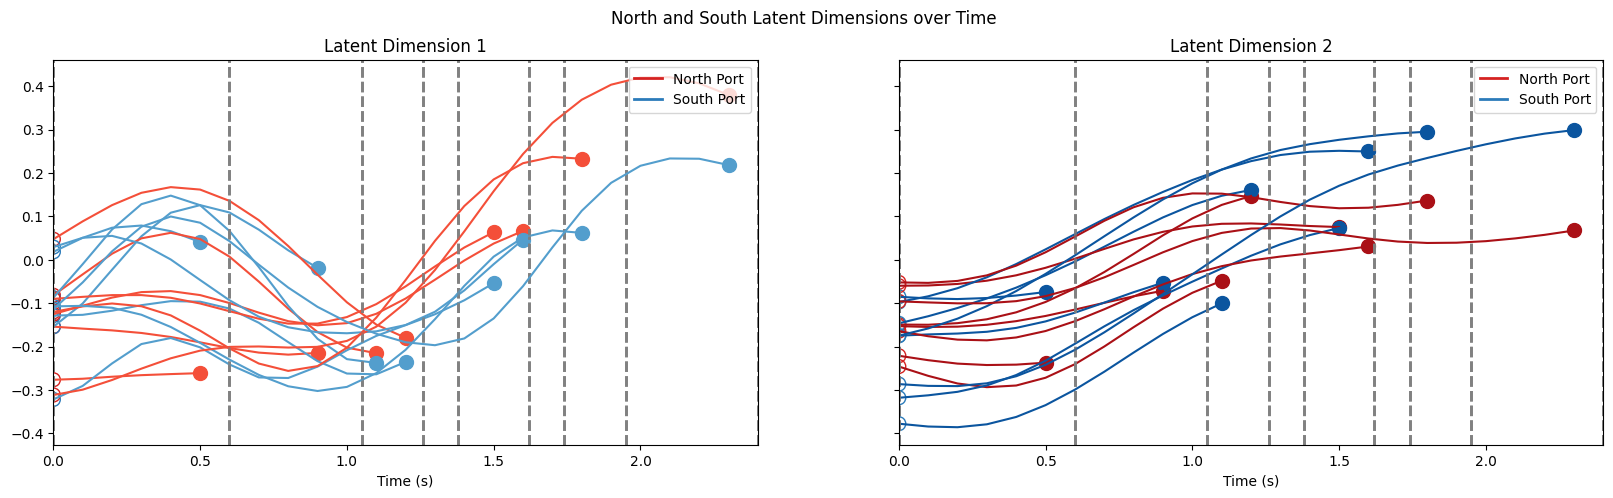

In [129]:
north_colors = ['#DC143C', '#F08080', '#8B0000']
south_colors = ['#4169E1', '#1E90FF', '#4682B4']

reds = plt.get_cmap('Reds')
blues = plt.get_cmap('Blues')
purps = plt.get_cmap('Purples')
north_colors_range = [reds(val) for val in (np.linspace(0, 1, 8))]
south_colors_range = [blues(val) for val in (np.linspace(0, 1, 8))]
cumulative_colors_range = [purps(val) for val in (np.linspace(0, 1, 8))]

# First 2 latent dimensions plotting against one another
# fig1, (ax1_1, ax1_2, ax1_3) = plt.subplots(1, 3, figsize=(20, 5))
# fig1.suptitle('First 2 Latent Dimensions')

# for stim in range(NUM_STIMS):
#     trials_start = n_cumulative_sum[stim]
#     trials_end = n_cumulative_sum[stim + 1]
#     avg_traj = np.mean(n_trajectories_2d_stim_dur[trials_start:trials_end], axis = 0)
# # for single_trial in n_trajectories:
# #     ax1.plot(single_trial[0], single_trial[1], '-', lw = 0.5, alpha = 0.5, c = 'grey')
#     ax1_1.plot(avg_traj[0], avg_traj[1], '-', lw = 2, label = 'North Trial averaged trajectory', color = north_colors_range[stim])
#     ax1_1.scatter(avg_traj[0][-1], avg_traj[1][-1], color = north_colors_range[stim], s = 100)
#     ax1_1.scatter(avg_traj[0][0], avg_traj[1][0], edgecolors = north_colors_range[stim], marker = 'o', facecolor = 'none', s = 100)
# ax1_1.set_title('North Starting Port')
# ax1_1.set_xlabel('Dimension 1')
# ax1_1.set_ylabel('Dimension 2')

# for stim in range(NUM_STIMS):
#     trials_start = s_cumulative_sum[stim]
#     trials_end = s_cumulative_sum[stim + 1]
#     avg_traj = np.mean(s_trajectories_2d_stim_dur[trials_start:trials_end], axis = 0)
# for single_trial in s_trajectories:
#     ax2.plot(single_trial[0], single_trial[1], '-', lw = 0.5, alpha = 0.5, c = 'grey')
# avg_traj = np.mean(GPFA_per_stim['S0_S_2D'], axis = 0)
#     ax1_2.plot(avg_traj[0], avg_traj[1], '-', lw = 2, label = 'Trial averaged trajectory', color = south_colors_range[stim])
#     ax1_2.scatter(avg_traj[0][-1], avg_traj[1][-1], color = south_colors_range[stim], s = 100)
#     ax1_2.scatter(avg_traj[0][0], avg_traj[1][0], edgecolors = south_colors_range[stim], marker = 'o', facecolor = 'none', s = 100)
# ax1_2.set_title('South Starting Port Latent dimensions')
# ax1_2.set_xlabel('Dimension 1')
# ax1_2.set_ylabel('Dimension 2')

# for stim in range(NUM_STIMS):
#     trials_start = cumulative_sum_list[stim]
#     trials_end = cumulative_sum_list[stim + 1]
#     avg_traj = np.mean(c_trajectories_2d_stim_dur[trials_start:trials_end], axis = 0)

# # for single_trial in s_trajectories:
# #     ax2.plot(single_trial[0], single_trial[1], '-', lw = 0.5, alpha = 0.5, c = 'grey')
#     ax1_3.plot(avg_traj[0], avg_traj[1], '-', lw = 2, label = 'Trial averaged trajectory', color = cumulative_colors_range[stim])
#     ax1_3.scatter(avg_traj[0][-1], avg_traj[1][-1], color = cumulative_colors_range[stim], s = 100)
#     ax1_3.scatter(avg_traj[0][0], avg_traj[1][0], edgecolors =cumulative_colors_range[stim], marker = 'o', facecolor = 'none', s = 100)
# ax1_3.set_title('Invariant Port')
# ax1_3.set_xlabel('Dimension 1')
# ax1_3.set_ylabel('Dimension 2')

# First 2 latent dimensions plotting against time 
fig2, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True) 
axes = axes.flatten()
fig2.suptitle('North and South Latent Dimensions over Time')

from matplotlib.lines import Line2D


for stim in range(NUM_STIMS):
    stim_time = times[stim + 1]
    ax_1 = axes[0]
    ax_2 = axes[1]
    
    trials_start = n_cumulative_sum[stim]
    trials_end = n_cumulative_sum[stim + 1]
    n_traj_chunk = n_trajectories_2d_stim_dur[trials_start:trials_end]
    n_traj_chunk = np.mean(n_traj_chunk, axis = 0)
    times_trajectory = np.arange(len(n_traj_chunk[0])) * bin_size.rescale('s')
    ax_1.plot(times_trajectory, n_traj_chunk[0], color= north_colors_range[4])
    ax_2.plot(times_trajectory, n_traj_chunk[1], color= north_colors_range[6])
    ax_1.scatter(times_trajectory[-1], n_traj_chunk[0][-1], marker = 'o', color= north_colors_range[4], s = 100)
    ax_2.scatter(times_trajectory[-1], n_traj_chunk[1][-1], marker = 'o', color= north_colors_range[6], s = 100)
    ax_1.scatter(times_trajectory[0], n_traj_chunk[0][0], facecolor= 'none', marker = 'o', edgecolors=north_colors_range[5], s = 100)
    ax_2.scatter(times_trajectory[0], n_traj_chunk[1][0], facecolor= 'none', marker = 'o', edgecolors=north_colors_range[5], s = 100)
    ax_1.set_xlabel('Time (s)')
    ax_1.set_xlim(0, 2.4)
    for xc in times:
        ax_1.axvline(x=xc/1000, color='grey', linestyle='--', linewidth=2, alpha = 0.4)
    ax_1.set_title('Latent Dimension 1')

    s_trials_start = s_cumulative_sum[stim]
    s_trials_end = s_cumulative_sum[stim + 1]
    s_traj_chunk = s_trajectories_2d_stim_dur[s_trials_start:s_trials_end]
    s_traj_chunk = np.mean(s_traj_chunk, axis = 0)
    times_trajectory = np.arange(len(s_traj_chunk[0])) * bin_size.rescale('s')
    ax_1.plot(times_trajectory, s_traj_chunk[0], color= south_colors_range[4])
    ax_2.plot(times_trajectory, s_traj_chunk[1], color= south_colors_range[6])
    ax_1.scatter(times_trajectory[-1], s_traj_chunk[0][-1], marker = 'o', color= south_colors_range[4], s = 100)
    ax_2.scatter(times_trajectory[-1], s_traj_chunk[1][-1], marker = 'o', color= south_colors_range[6], s = 100)
    ax_1.scatter(times_trajectory[0], s_traj_chunk[0][0], facecolor= 'none', marker = 'o', edgecolors=south_colors_range[5], s = 100)
    ax_2.scatter(times_trajectory[0], s_traj_chunk[1][0], facecolor= 'none', marker = 'o', edgecolors=south_colors_range[5], s = 100)
    ax_2.set_xlabel('Time (s)')
    ax_2.set_xlim(0, 2.4)
    for xc in times:
        ax_2.axvline(x=xc/1000, color='grey', linestyle='--', linewidth=2, alpha = 0.4)
    ax_2.set_title('Latent Dimension 2')

legend_elements = [
    Line2D([0], [0], color=north_colors_range[5], lw=2, label='North Port'),
    Line2D([0], [0], color=south_colors_range[5], lw=2, label='South Port'),
]

# Add the legend to the first axis (ax_1)
axes[0].legend(handles=legend_elements, loc='upper right')
axes[1].legend(handles=legend_elements, loc='upper right')

plt.show()


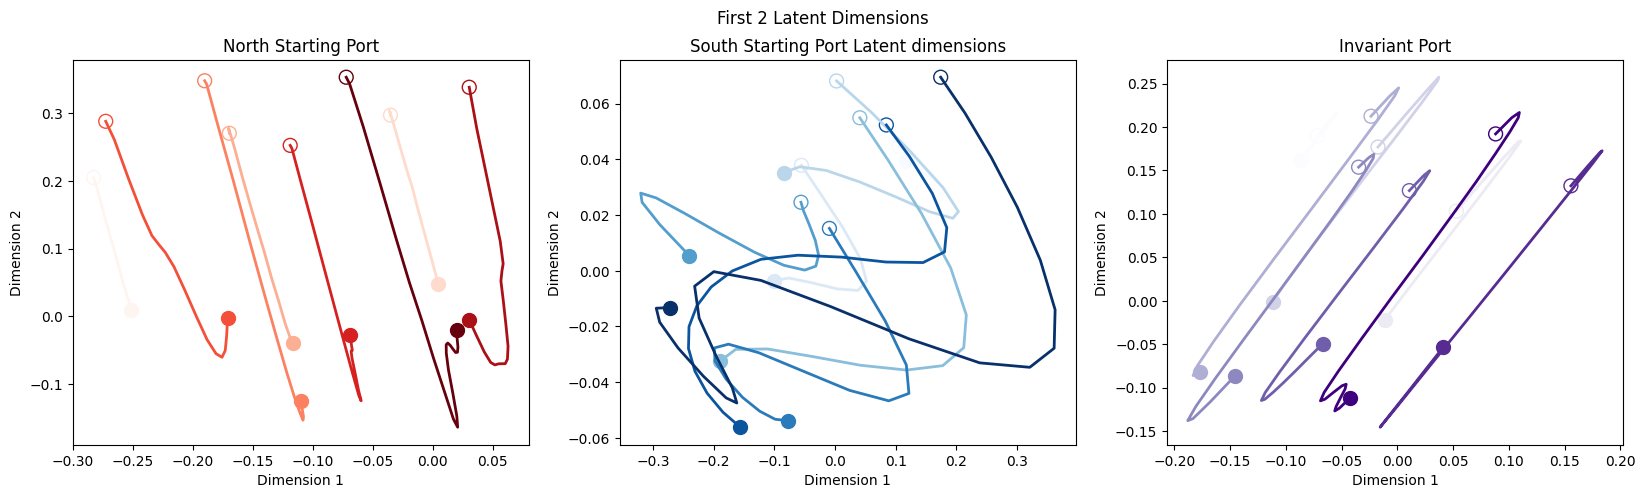

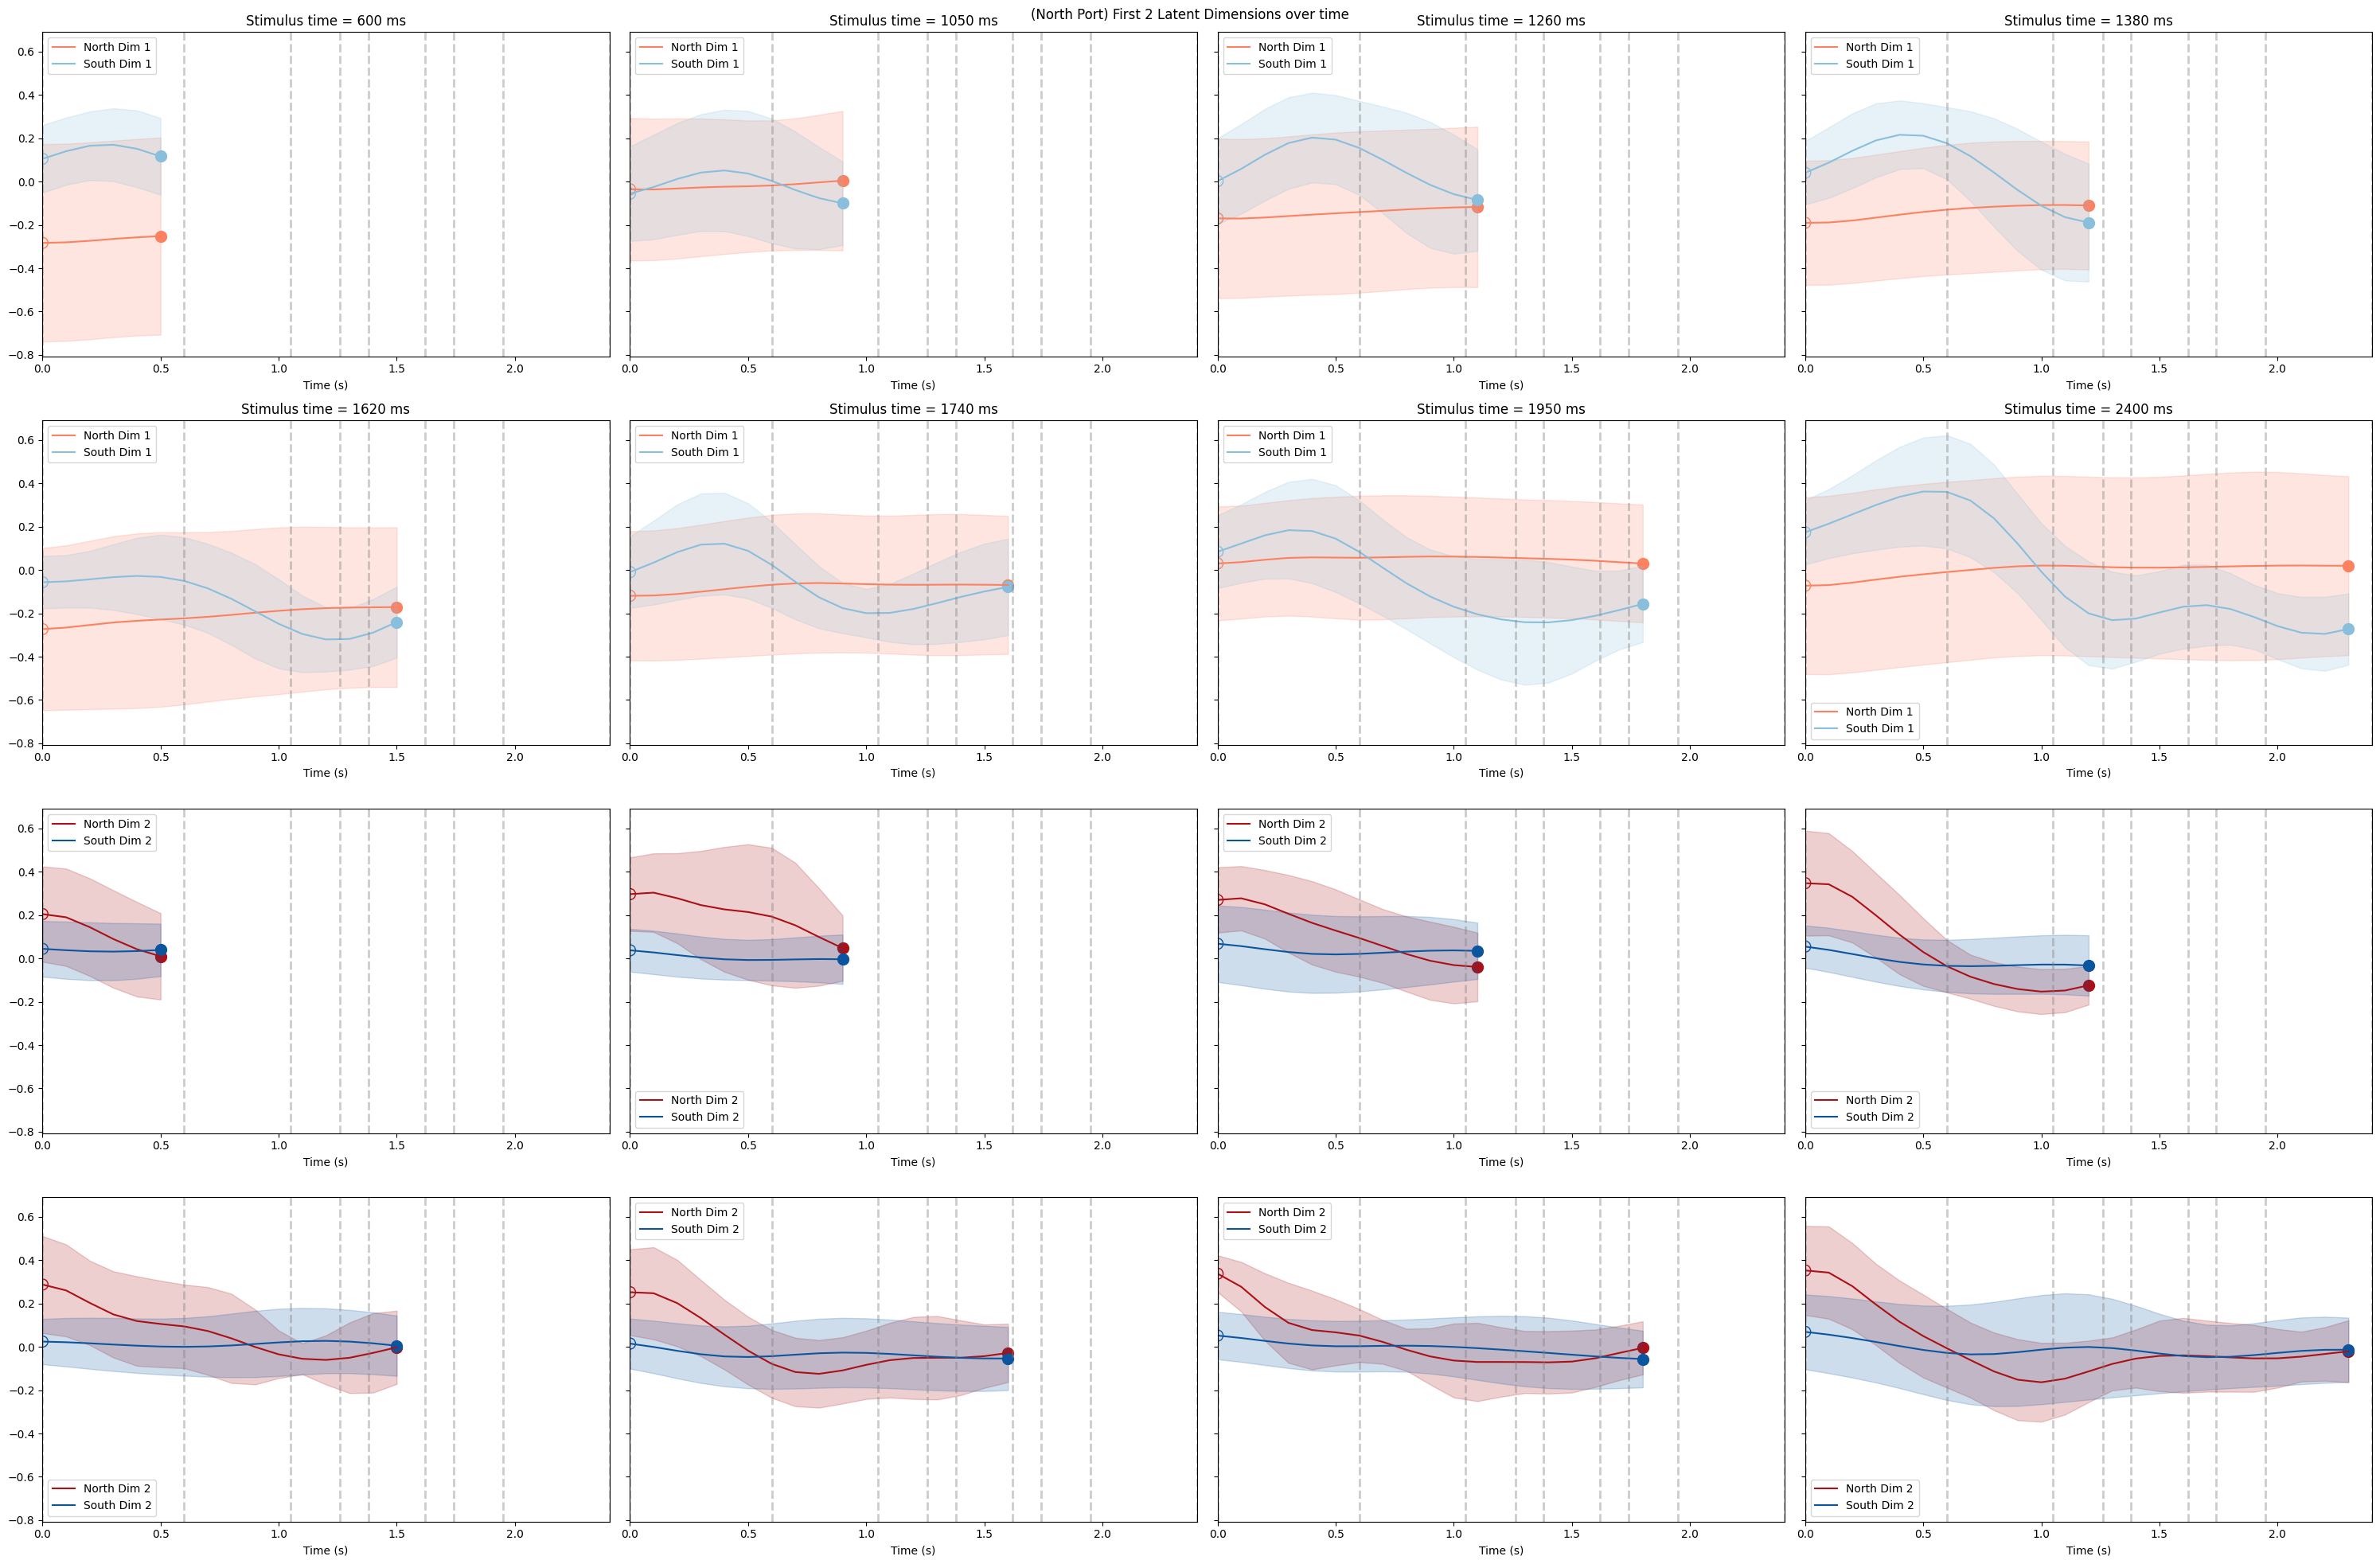

In [79]:
reds = plt.get_cmap('Reds')
blues = plt.get_cmap('Blues')
purps = plt.get_cmap('Purples')
north_colors_range = [reds(val) for val in (np.linspace(0, 1, 8))]
south_colors_range = [blues(val) for val in (np.linspace(0, 1, 8))]
cumulative_colors_range = [purps(val) for val in (np.linspace(0, 1, 8))]

# First 2 latent dimensions plotting against one another
fig1, (ax1_1, ax1_2, ax1_3) = plt.subplots(1, 3, figsize=(20, 5))
fig1.suptitle('First 2 Latent Dimensions')

# North Starting Port
for stim in range(NUM_STIMS):
    trials_start = n_cumulative_sum[stim]
    trials_end = n_cumulative_sum[stim + 1]
    avg_traj = np.mean(n_trajectories_2d_stim_dur[trials_start:trials_end], axis=0)
    ax1_1.plot(avg_traj[0], avg_traj[1], '-', lw=2, label='North Trial averaged trajectory', color=north_colors_range[stim])
    ax1_1.scatter(avg_traj[0][-1], avg_traj[1][-1], color=north_colors_range[stim], s=100)
    ax1_1.scatter(avg_traj[0][0], avg_traj[1][0], edgecolors=north_colors_range[stim], marker='o', facecolor='none', s=100)
ax1_1.set_title('North Starting Port')
ax1_1.set_xlabel('Dimension 1')
ax1_1.set_ylabel('Dimension 2')

# South Starting Port
for stim in range(NUM_STIMS):
    trials_start = s_cumulative_sum[stim]
    trials_end = s_cumulative_sum[stim + 1]
    avg_traj = np.mean(s_trajectories_2d_stim_dur[trials_start:trials_end], axis=0)
    ax1_2.plot(avg_traj[0], avg_traj[1], '-', lw=2, label='Trial averaged trajectory', color=south_colors_range[stim])
    ax1_2.scatter(avg_traj[0][-1], avg_traj[1][-1], color=south_colors_range[stim], s=100)
    ax1_2.scatter(avg_traj[0][0], avg_traj[1][0], edgecolors=south_colors_range[stim], marker='o', facecolor='none', s=100)
ax1_2.set_title('South Starting Port Latent dimensions')
ax1_2.set_xlabel('Dimension 1')
ax1_2.set_ylabel('Dimension 2')

# Invariant Port
for stim in range(NUM_STIMS):
    trials_start = cumulative_sum_list[stim]
    trials_end = cumulative_sum_list[stim + 1]
    avg_traj = np.mean(c_trajectories_2d_stim_dur[trials_start:trials_end], axis=0)
    ax1_3.plot(avg_traj[0], avg_traj[1], '-', lw=2, label='Trial averaged trajectory', color=cumulative_colors_range[stim])
    ax1_3.scatter(avg_traj[0][-1], avg_traj[1][-1], color=cumulative_colors_range[stim], s=100)
    ax1_3.scatter(avg_traj[0][0], avg_traj[1][0], edgecolors=cumulative_colors_range[stim], marker='o', facecolor='none', s=100)
ax1_3.set_title('Invariant Port')
ax1_3.set_xlabel('Dimension 1')
ax1_3.set_ylabel('Dimension 2')


def plot_trajectory_with_variance(ax, avg_traj, traj_var, color, label_prefix):
    """Plot average trajectory with variance shaded area."""
    ax.plot(avg_traj[0], avg_traj[1], '-', lw=2, color=color, label=f'{label_prefix} averaged trajectory')
    # ax.fill_betweenx(avg_traj[1], avg_traj[0] - traj_var[0], avg_traj[0] + traj_var[0], color=color, alpha=0.2)
    ax.scatter(avg_traj[0][-1], avg_traj[1][-1], color=color, s=100)
    ax.scatter(avg_traj[0][0], avg_traj[1][0], edgecolors=color, marker='o', facecolor='none', s=100)


def plot_latent_dimensions_over_time(times, bin_size, n_trajectories, s_trajectories, n_cumsum, s_cumsum):
    """Plot first 2 latent dimensions over time for North and South trajectories."""
    fig, axes = plt.subplots(4, 4, figsize=(30, 20), sharey=True)
    axes = axes.flatten()
    fig.suptitle('(North Port) First 2 Latent Dimensions over time')

    for stim in range(NUM_STIMS):
        stim_time = times[stim + 1]
        ax_1 = axes[stim]
        ax_2 = axes[stim + NUM_STIMS]

        # North Trajectories
        trials_start, trials_end = n_cumsum[stim], n_cumsum[stim + 1]
        n_traj_chunk = np.mean(n_trajectories[trials_start:trials_end], axis=0)
        n_traj_var = np.std(n_trajectories[trials_start:trials_end], axis=0)
        times_trajectory = np.arange(len(n_traj_chunk[0])) * bin_size.rescale('s')
        
        ax_1.plot(times_trajectory, n_traj_chunk[0], color=north_colors_range[3], label="North Dim 1")
        ax_1.fill_between(times_trajectory, n_traj_chunk[0] - n_traj_var[0], n_traj_chunk[0] + n_traj_var[0], color=north_colors_range[3], alpha=0.2)
        ax_2.plot(times_trajectory, n_traj_chunk[1], color=north_colors_range[6], label="North Dim 2")
        ax_2.fill_between(times_trajectory, n_traj_chunk[1] - n_traj_var[1], n_traj_chunk[1] + n_traj_var[1], color=north_colors_range[6], alpha=0.2)

        # Scatter Points for North
        ax_1.scatter(times_trajectory[-1], n_traj_chunk[0][-1], marker='o', color=north_colors_range[3], s=100)
        ax_2.scatter(times_trajectory[-1], n_traj_chunk[1][-1], marker='o', color=north_colors_range[6], s=100)
        ax_1.scatter(times_trajectory[0], n_traj_chunk[0][0], facecolor='none', marker='o', edgecolors=north_colors_range[3], s=100)
        ax_2.scatter(times_trajectory[0], n_traj_chunk[1][0], facecolor='none', marker='o', edgecolors=north_colors_range[6], s=100)

        # South Trajectories
        trials_start, trials_end = s_cumsum[stim], s_cumsum[stim + 1]
        s_traj_chunk = np.mean(s_trajectories[trials_start:trials_end], axis=0)
        s_traj_var = np.std(s_trajectories[trials_start:trials_end], axis=0)
        
        ax_1.plot(times_trajectory, s_traj_chunk[0], color=south_colors_range[3], label="South Dim 1")
        ax_1.fill_between(times_trajectory, s_traj_chunk[0] - s_traj_var[0], s_traj_chunk[0] + s_traj_var[0], color=south_colors_range[3], alpha=0.2)
        ax_2.plot(times_trajectory, s_traj_chunk[1], color=south_colors_range[6], label="South Dim 2")
        ax_2.fill_between(times_trajectory, s_traj_chunk[1] - s_traj_var[1], s_traj_chunk[1] + s_traj_var[1], color=south_colors_range[6], alpha=0.2)

        # Scatter Points for South
        ax_1.scatter(times_trajectory[-1], s_traj_chunk[0][-1], marker='o', color=south_colors_range[3], s=100)
        ax_2.scatter(times_trajectory[-1], s_traj_chunk[1][-1], marker='o', color=south_colors_range[6], s=100)
        ax_1.scatter(times_trajectory[0], s_traj_chunk[0][0], facecolor='none', marker='o', edgecolors=south_colors_range[3], s=100)
        ax_2.scatter(times_trajectory[0], s_traj_chunk[1][0], facecolor='none', marker='o', edgecolors=south_colors_range[6], s=100)

        # Vertical Lines
        ax_1.set_xlabel('Time (s)')
        ax_1.set_xlim(0, 2.4)
        ax_2.set_xlabel('Time (s)')
        ax_2.set_xlim(0, 2.4)
        for xc in times:
            ax_1.axvline(x=xc/1000, color='grey', linestyle='--', linewidth=2, alpha=0.4)
            ax_2.axvline(x=xc/1000, color='grey', linestyle='--', linewidth=2, alpha=0.4)
        
        ax_1.set_title(f'Stimulus time = {stim_time} ms')
        ax_1.legend()
        ax_2.legend()

    plt.tight_layout()

plot_latent_dimensions_over_time(times, bin_size, n_trajectories_2d_stim_dur, s_trajectories_2d_stim_dur,
                                 n_cumulative_sum, s_cumulative_sum)


In [80]:
# TRIAL_NUM = 2
# fig, axes = plt.subplots(2, 4, figsize=(24, 10)) 
# axes = axes.flatten()

# for stim in range(NUM_STIMS):
#     stim_time = times[stim + 1]
#     ax = axes[stim]
#     trials_start = cumulative_sum_list[stim]
#     trials_end = cumulative_sum_list[stim + 1]
#     c_traj_chunk = c_trajectories_2d[trials_start:trials_end]
#     times_trajectory = np.arange(len(c_traj_chunk[TRIAL_NUM][0])) * bin_size.rescale('s')
#     ax.plot(times_trajectory, c_traj_chunk[TRIAL_NUM][0], color= cumulative_colors_range[3], label="Dim 1")
#     ax.plot(times_trajectory, c_traj_chunk[TRIAL_NUM][1], color= cumulative_colors_range[6], label="Dim 2")
#     ax.scatter(times_trajectory[-1], c_traj_chunk[TRIAL_NUM][0][-1], marker = 'o', color= south_colors_range[3], s = 100)
#     ax.scatter(times_trajectory[-1], c_traj_chunk[TRIAL_NUM][1][-1], marker = 'o', color= south_colors_range[6], s = 100)
#     ax.scatter(times_trajectory[0], c_traj_chunk[TRIAL_NUM][0][0], facecolor= 'none', marker = 'o', edgecolors=south_colors_range[3], s = 100)
#     ax.scatter(times_trajectory[0], c_traj_chunk[TRIAL_NUM][1][0], facecolor= 'none', marker = 'o', edgecolors=south_colors_range[6], s = 100)
#     ax.set_xlabel('Time (s)')
#     ax.set_xlim(0, 2.4)
#     for xc in times:
#         ax.axvline(x=xc/1000, color='grey', linestyle='--', linewidth=2, alpha = 0.4)
#     ax.set_title(f'Stimulus time = {stim_time} ms')

# fig4 = plt.figure(figsize=(14, 6))
# ax3_1 = fig4.add_subplot(1, 2, 1, projection = '3d')
# ax3_2 = fig4.add_subplot(1, 2, 2, projection = '3d')
# fig4.suptitle('First 3 Latent Dimensions')
# for stim in range(NUM_STIMS):
#     trials_start = n_cumulative_sum[stim]
#     trials_end = n_cumulative_sum[stim + 1]
#     n_avg_traj_3d = np.mean(n_trajectories_3d_stim_dur[trials_start:trials_end], axis = 0)   
# # for single_trial in n_trajectories_3d:
# #     ax1.plot(single_trial[0], single_trial[1], single_trial[2], lw = 0.5, c = 'grey', alpha = 0.5)
# # n_avg_traj_3d = np.mean(n_trajectories_3d, axis = 0)
#     ax3_1.plot(n_avg_traj_3d[0], n_avg_traj_3d[1], n_avg_traj_3d[2], lw = 2, color = north_colors_range[stim], label = 'Trial averaged trajectory')
#     ax3_1.scatter(n_avg_traj_3d[0][-1], n_avg_traj_3d[1][-1], n_avg_traj_3d[2][-1], color = north_colors_range[stim], s = 100)
#     ax3_1.scatter(n_avg_traj_3d[0][0], n_avg_traj_3d[1][0], n_avg_traj_3d[2][0], edgecolors=north_colors_range[stim], s = 100, facecolor = 'none', marker = 'o')

# ax3_1.set_title('North Port')
# ax3_1.set_xlabel('Dim 1')
# ax3_1.set_ylabel('Dim 2')
# ax3_1.set_zlabel('Dim 3')

# for stim in range(NUM_STIMS):
#     trials_start = s_cumulative_sum[stim]
#     trials_end = s_cumulative_sum[stim + 1]
#     s_avg_traj_3d = np.mean(s_trajectories_3d_stim_dur[trials_start:trials_end], axis = 0)
# # for single_trial in s_trajectories_3d:
# #     ax2.plot(single_trial[0], single_trial[1], single_trial[2], lw = 0.5, c = 'grey', alpha = 0.5)
# # s_avg_traj_3d = np.mean(s_trajectories_3d, axis = 0)
#     ax3_2.plot(s_avg_traj_3d[0], s_avg_traj_3d[1], s_avg_traj_3d[2], lw = 2, color = south_colors_range[stim], label = 'Trial averaged trajectory')
#     ax3_2.scatter(s_avg_traj_3d[0][-1], s_avg_traj_3d[1][-1], s_avg_traj_3d[2][-1], color = south_colors_range[stim], s = 100)
#     ax3_2.scatter(s_avg_traj_3d[0][0], s_avg_traj_3d[1][0], s_avg_traj_3d[2][0], edgecolors=south_colors_range[stim], s = 100, facecolor = 'none', marker = 'o')

# ax3_2.set_title('South Port')
# ax3_2.set_xlabel('Dim 1')
# ax3_2.set_ylabel('Dim 2')
# ax3_2.set_zlabel('Dim 3')

# fig5, axes = plt.subplots(2, 4, figsize=(24, 10)) 
# axes = axes.flatten()
# fig5.suptitle('(North Port) First 3 Latent Dimensions over time')

# for stim in range(NUM_STIMS):
#     stim_time = times[stim + 1]
#     ax = axes[stim]
#     trials_start = n_cumulative_sum[stim]
#     trials_end = n_cumulative_sum[stim + 1] 
#     n_traj_chunk_avg = np.mean(n_trajectories_3d_stim_dur[trials_start:trials_end], axis = 0)
#     x_axis = np.arange(len(n_traj_chunk_avg[0])) * bin_size.rescale('s')
#     for i, x in enumerate(n_traj_chunk_avg):
#         ax.plot(np.arange(len(x))*(GPFA_BIN_SIZE/1000), x, label=f'Dim {i+1}', color = north_colors_range[(i+1) * 2])
#         ax.scatter((len(x))*(GPFA_BIN_SIZE/1000), x[-1], color = north_colors_range[(i+1)*2], s = 100)
#         ax.scatter(0, x[0], color = north_colors_range[(i+1)*2], facecolor = 'none', marker = 'o', edgecolors=north_colors_range[(i+1) * 2], s = 100)

#     ax.legend()
#     ax.set_xlabel('Time (s)')
#     ax.set_xlim(0, 2.4)
#     for xc in times:
#         ax.axvline(x=xc/1000, color='grey', linestyle='--', linewidth=2, alpha = 0.4)
#     ax.set_title(f'Stimulus time = {stim_time} ms')

# fig6, axes = plt.subplots(2, 4, figsize=(24, 10)) 
# axes = axes.flatten()
# fig6.suptitle('(South Port) First 3 Latent Dimensions over time')

# for stim in range(NUM_STIMS):
#     stim_time = times[stim + 1]
#     ax = axes[stim]
#     trials_start = s_cumulative_sum[stim]
#     trials_end = s_cumulative_sum[stim + 1] 
#     s_traj_chunk_avg = np.mean(s_trajectories_3d_stim_dur[trials_start:trials_end], axis = 0)
#     x_axis = np.arange(len(s_traj_chunk_avg[0])) * bin_size.rescale('s')
#     for i, x in enumerate(s_traj_chunk_avg):
#         ax.plot(np.arange(len(x))*(GPFA_BIN_SIZE/1000), x, label=f'Dim {i+1}', color = south_colors_range[(i+1) * 2])
#         ax.scatter((len(x))*(GPFA_BIN_SIZE/1000), x[-1], color = south_colors_range[(i+1)*2], s = 100)
#         ax.scatter(0, x[0], color = north_colors_range[(i+1)*2], facecolor = 'none', marker = 'o', edgecolors=south_colors_range[(i+1) * 2], s = 100)

#     ax.legend()
#     ax.set_xlabel('Time (s)')
#     ax.set_xlim(0, 2.4)
#     for xc in times:
#         ax.axvline(x=xc/1000, color='grey', linestyle='--', linewidth=2, alpha = 0.4)

#     ax.set_title(f'Stimulus time = {stim_time} ms')

### Feedback Period

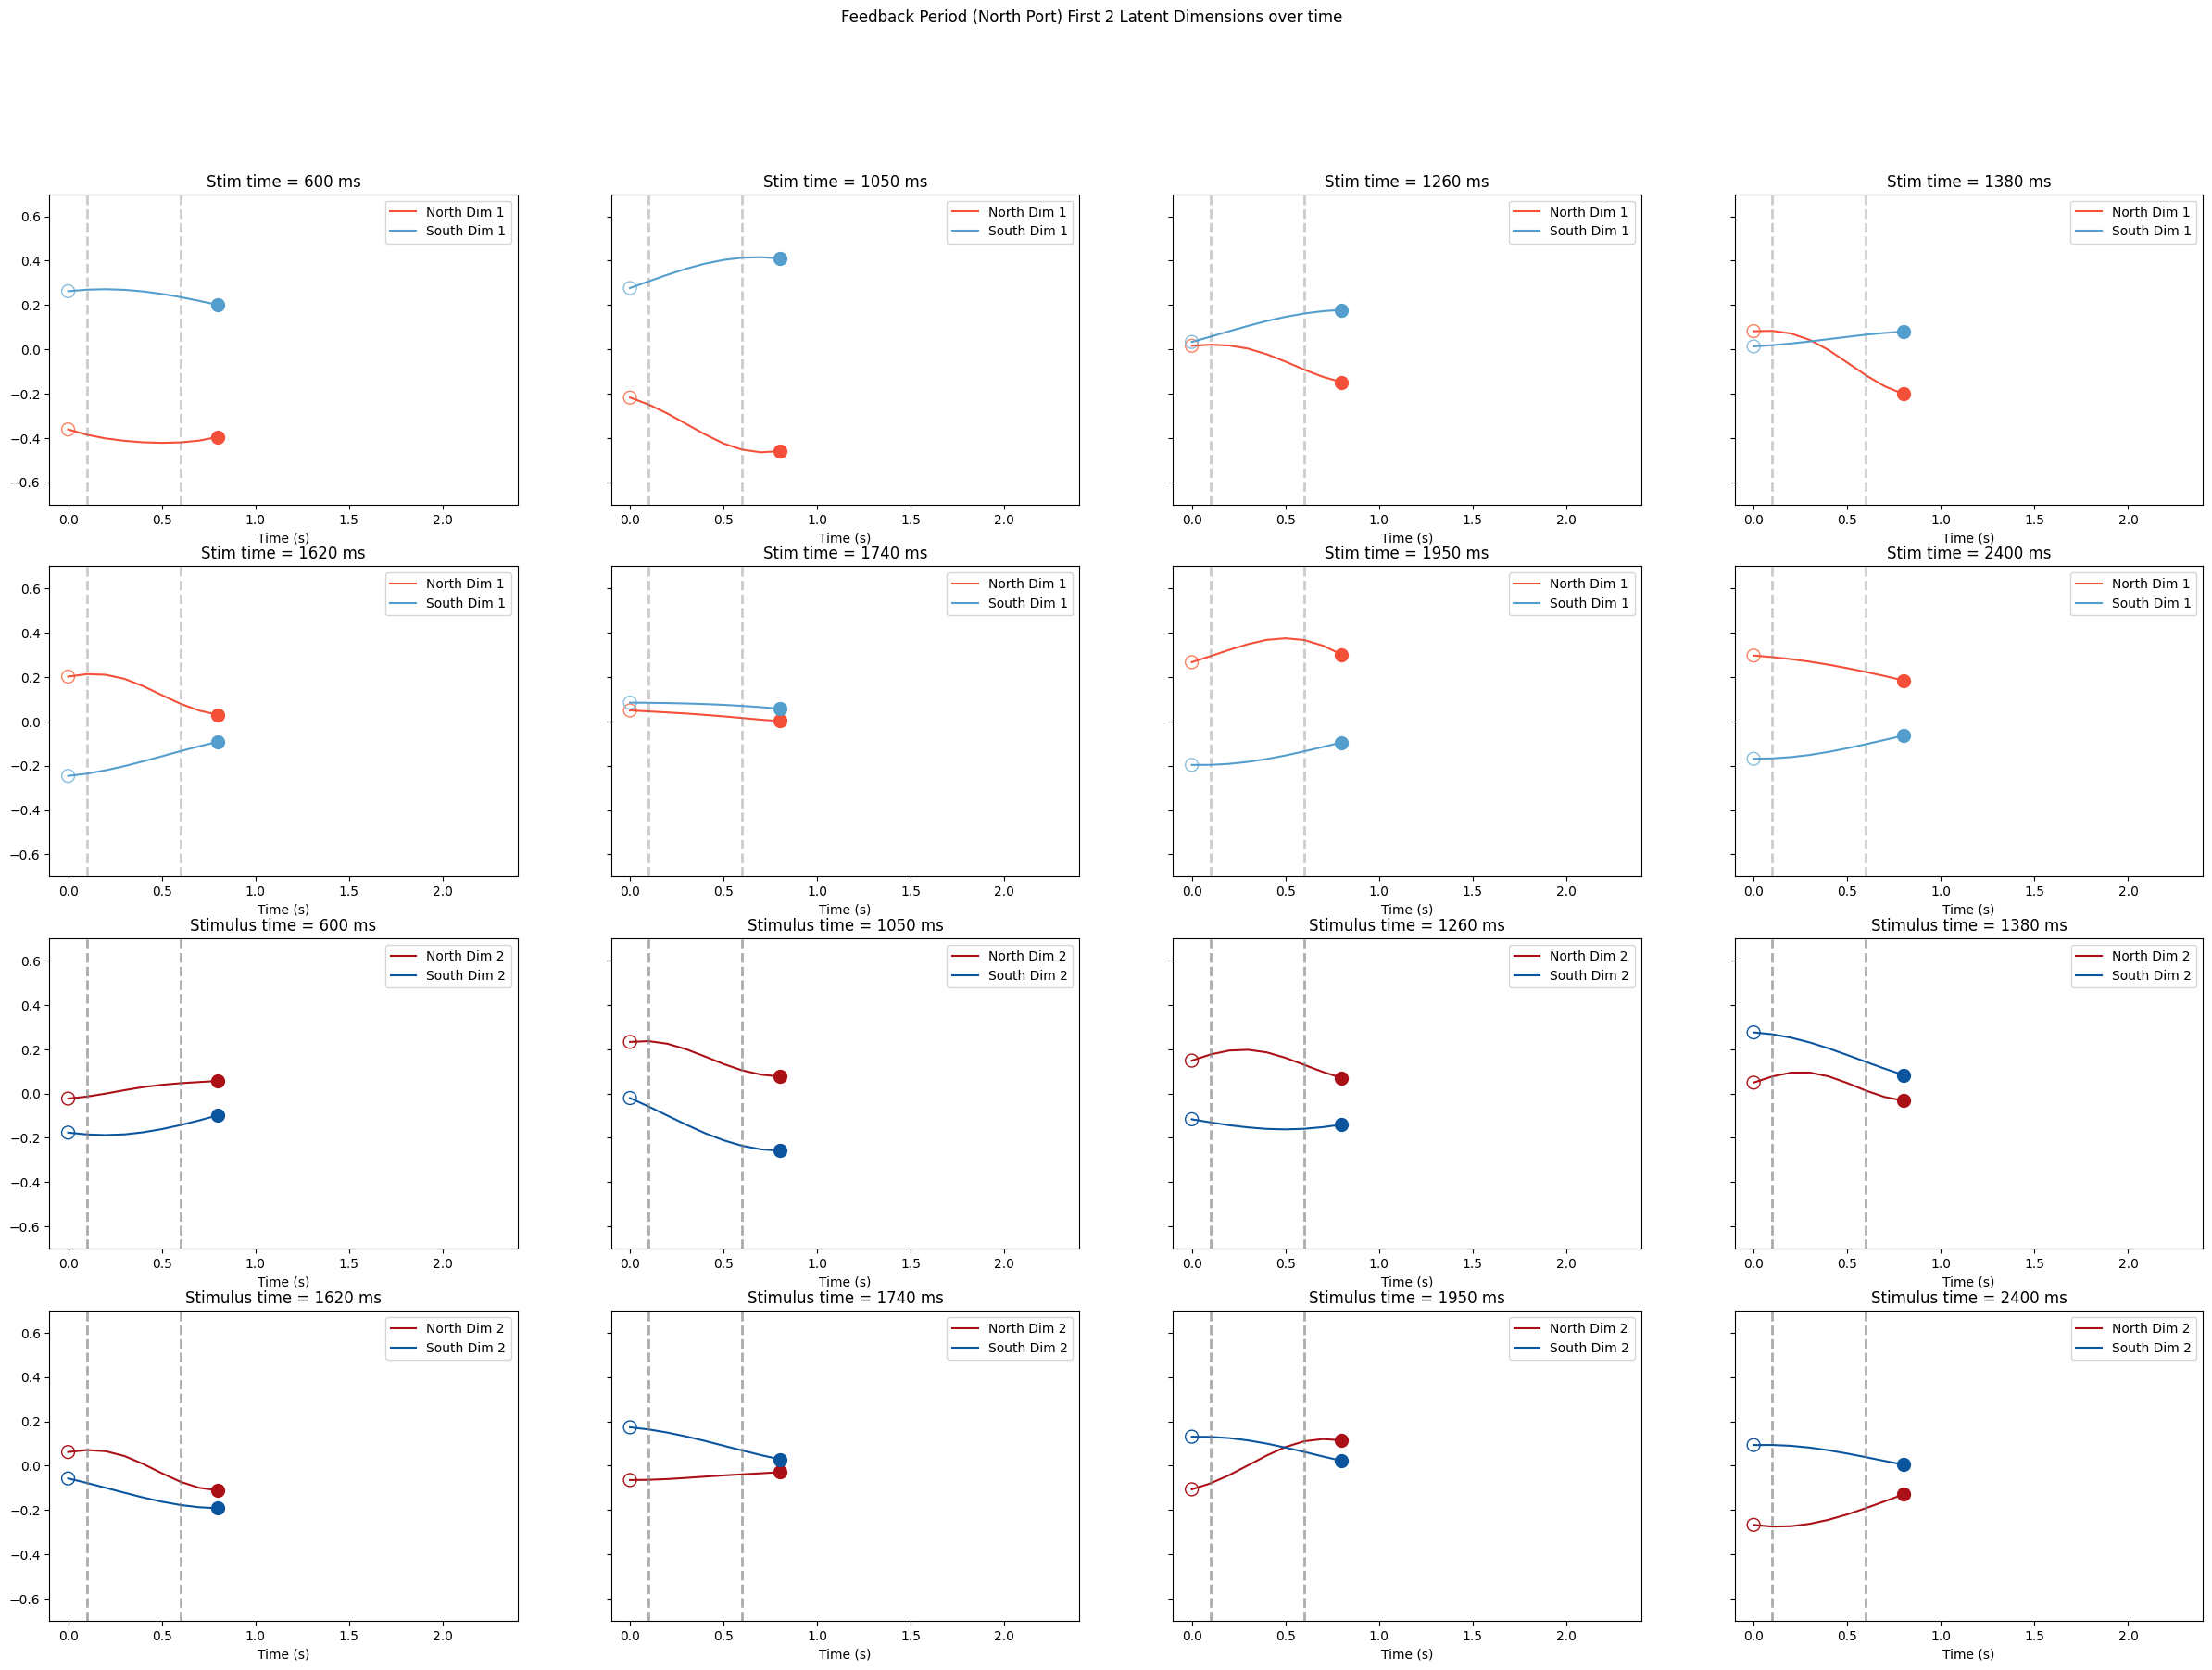

In [130]:
north_colors = ['#DC143C', '#F08080', '#8B0000']
south_colors = ['#4169E1', '#1E90FF', '#4682B4']

reds = plt.get_cmap('Reds')
blues = plt.get_cmap('Blues')
purps = plt.get_cmap('Purples')
north_colors_range = [reds(val) for val in (np.linspace(0, 1, 8))]
south_colors_range = [blues(val) for val in (np.linspace(0, 1, 8))]


# First 2 latent dimensions plotting against one another
# fig1, (ax1_1, ax1_2, ax1_3) = plt.subplots(1, 3, figsize=(20, 5))
# fig1.suptitle('Feedback Period First 2 Latent Dimensions')

# for stim in range(NUM_STIMS):
#     trials_start = n_cumulative_sum[stim]
#     trials_end = n_cumulative_sum[stim + 1]
#     avg_traj = np.mean(n_trajectories_2d_reward[trials_start:trials_end], axis = 0)
# # for single_trial in n_trajectories:
# #     ax1.plot(single_trial[0], single_trial[1], '-', lw = 0.5, alpha = 0.5, c = 'grey')
#     ax1_1.plot(avg_traj[0], avg_traj[1], '-', lw = 2, label = 'North Trial averaged trajectory', color = north_colors_range[stim])
#     ax1_1.scatter(avg_traj[0][-1], avg_traj[1][-1], color = north_colors_range[stim], s = 100)
#     ax1_1.scatter(avg_traj[0][0], avg_traj[1][0], edgecolors = north_colors_range[stim], marker = 'o', facecolor = 'none', s = 100)
# ax1_1.set_title('North Starting Port')
# ax1_1.set_xlabel('Dimension 1')
# ax1_1.set_ylabel('Dimension 2')

# for stim in range(NUM_STIMS):
#     trials_start = s_cumulative_sum[stim]
#     trials_end = s_cumulative_sum[stim + 1]
#     avg_traj = np.mean(s_trajectories_2d_reward[trials_start:trials_end], axis = 0)
# # for single_trial in s_trajectories:
# #     ax2.plot(single_trial[0], single_trial[1], '-', lw = 0.5, alpha = 0.5, c = 'grey')
# # avg_traj = np.mean(GPFA_per_stim['S0_S_2D'], axis = 0)
#     ax1_2.plot(avg_traj[0], avg_traj[1], '-', lw = 2, label = 'South Trial averaged trajectory', color = south_colors_range[stim])
#     ax1_2.scatter(avg_traj[0][-1], avg_traj[1][-1], color = south_colors_range[stim], s = 100)
#     ax1_2.scatter(avg_traj[0][0], avg_traj[1][0], edgecolors = south_colors_range[stim], marker = 'o', facecolor = 'none', s = 100)
# ax1_2.set_title('South Starting Port Latent dimensions')
# ax1_2.set_xlabel('Dimension 1')
# ax1_2.set_ylabel('Dimension 2')

# for stim in range(NUM_STIMS):
#     trials_start = cumulative_sum_list[stim]
#     trials_end = cumulative_sum_list[stim + 1]
#     avg_traj = np.mean(c_trajectories_2d_reward[trials_start:trials_end], axis = 0)

# # for single_trial in s_trajectories:
# #     ax2.plot(single_trial[0], single_trial[1], '-', lw = 0.5, alpha = 0.5, c = 'grey')
#     ax1_3.plot(avg_traj[0], avg_traj[1], '-', lw = 2, label = 'Trial averaged trajectory', color = cumulative_colors_range[stim])
#     ax1_3.scatter(avg_traj[0][-1], avg_traj[1][-1], color = cumulative_colors_range[stim], s = 100)
#     ax1_3.scatter(avg_traj[0][0], avg_traj[1][0], edgecolors =cumulative_colors_range[stim], marker = 'o', facecolor = 'none', s = 100)
# ax1_3.set_title('Invariant Port')
# ax1_3.set_xlabel('Dimension 1')
# ax1_3.set_ylabel('Dimension 2')

# First 2 latent dimensions plotting against time 
fig2, axes = plt.subplots(4, 4, figsize=(30, 20), sharey = True) 
axes = axes.flatten()

fig2.suptitle('Feedback Period (North Port) First 2 Latent Dimensions over time')

for stim in range(NUM_STIMS):

    stim_time = times[stim + 1]
    ax_1 = axes[stim]
    ax_2 = axes[stim + 8]
    trials_start = n_cumulative_sum[stim]
    trials_end = n_cumulative_sum[stim + 1]
    n_traj_chunk = n_trajectories_2d_reward[trials_start:trials_end]
    n_traj_chunk = np.mean(n_traj_chunk, axis = 0)
    
    times_trajectory = np.arange(len(n_traj_chunk[0])) * bin_size.rescale('s')
    ax_1.plot(times_trajectory, n_traj_chunk[0], color= north_colors_range[4], label="North Dim 1")
    ax_2.plot(times_trajectory, n_traj_chunk[1], color= north_colors_range[6], label="North Dim 2")
    ax_1.scatter(times_trajectory[-1], n_traj_chunk[0][-1], marker = 'o', color= north_colors_range[4], s = 100)
    ax_2.scatter(times_trajectory[-1], n_traj_chunk[1][-1], marker = 'o', color= north_colors_range[6], s = 100)
    ax_1.scatter(times_trajectory[0], n_traj_chunk[0][0], facecolor= 'none', marker = 'o', edgecolors=north_colors_range[3], s = 100)
    ax_2.scatter(times_trajectory[0], n_traj_chunk[1][0], facecolor= 'none', marker = 'o', edgecolors=north_colors_range[6], s = 100)
    ax_1.set_xlabel('Time (s)')
    ax_1.axvline(x=(((TIME_BEFORE_FBK * -1))/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
    ax_1.axvline(x=(((TIME_BEFORE_FBK * -1) + FEEDBACK_DELAY)/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
    ax_1.set_title(f'Stim time = {stim_time} ms')

    s_trials_start = s_cumulative_sum[stim]
    s_trials_end = s_cumulative_sum[stim + 1]
    s_traj_chunk = s_trajectories_2d_reward[s_trials_start:s_trials_end]
    s_traj_chunk = np.mean(s_traj_chunk, axis = 0)
    s_traj_std = np.std(s_traj_chunk, axis=0)    # Shape: (2, timepoints)

    s_traj_std = np.std(s_traj_chunk, axis=0)

    times_trajectory = np.arange(len(s_traj_chunk[0])) * bin_size.rescale('s')
    ax_1.plot(times_trajectory, s_traj_chunk[0], color= south_colors_range[4], label="South Dim 1")
    ax_2.plot(times_trajectory, s_traj_chunk[1], color= south_colors_range[6], label="South Dim 2")
    ax_1.scatter(times_trajectory[-1], s_traj_chunk[0][-1], marker = 'o', color= south_colors_range[4], s = 100)
    ax_2.scatter(times_trajectory[-1], s_traj_chunk[1][-1], marker = 'o', color= south_colors_range[6], s = 100)
    ax_1.scatter(times_trajectory[0], s_traj_chunk[0][0], facecolor= 'none', marker = 'o', edgecolors=south_colors_range[3], s = 100)
    ax_2.scatter(times_trajectory[0], s_traj_chunk[1][0], facecolor= 'none', marker = 'o', edgecolors=south_colors_range[6], s = 100)
    ax_2.set_xlabel('Time (s)')

    ax_1.set_xlim(-0.1, 2.4)
    ax_2.set_ylim(-0.7, 0.7)
    ax_2.set_xlim(-0.1, 2.4)
    ax_2.set_ylim(-0.7, 0.7)
    ax_2.axvline(x=(((TIME_BEFORE_FBK * -1))/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
    ax_2.axvline(x=(((TIME_BEFORE_FBK * -1) + FEEDBACK_DELAY)/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)    
    ax_2.axvline(x=(((TIME_BEFORE_FBK * -1))/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
    ax_2.axvline(x=(((TIME_BEFORE_FBK * -1) + FEEDBACK_DELAY)/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
    ax_2.set_title(f'Stimulus time = {stim_time} ms')
    ax_1.legend()
    ax_2.legend()


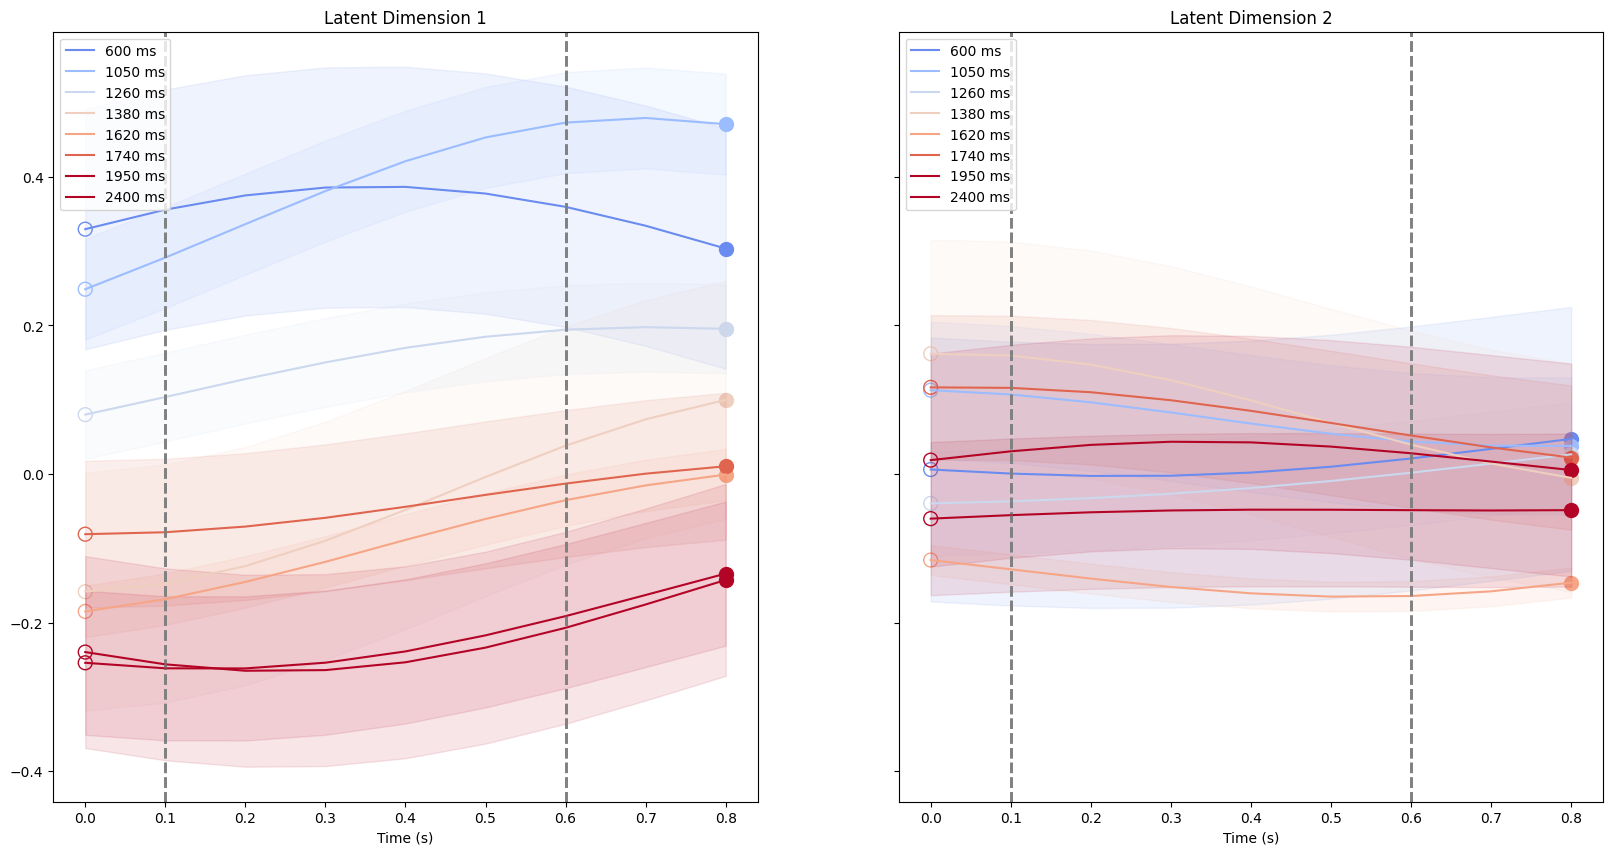

In [131]:
fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey = True)
purps = plt.get_cmap('coolwarm')

cumulative_colors_range = [purps(val + 0.15) for val in (np.linspace(0, 1, 8))]
for stim in range(NUM_STIMS):


    stim_time = times[stim + 1]
    ax_1 = axes[stim]
    ax_2 = axes[stim + 8]
    trials_start = cumulative_sum_list[stim]
    trials_end = cumulative_sum_list[stim + 1]
    c_traj_chunk = c_trajectories_2d_reward[trials_start:trials_end]
    c_traj_chunk = np.mean(c_traj_chunk, axis = 0)
    c_traj_var = np.std(c_traj_chunk, axis = 0)

    times_trajectory = np.arange(len(c_traj_chunk[0])) * bin_size.rescale('s')
    axs[0].plot(times_trajectory, c_traj_chunk[0], color= cumulative_colors_range[stim], label=f"{times[stim + 1]} ms")
    axs[1].plot(times_trajectory, c_traj_chunk[1], color= cumulative_colors_range[stim], label=f"{times[stim + 1]} ms")
    axs[0].fill_between(times_trajectory, c_traj_chunk[0] - c_traj_var[0], c_traj_chunk[0] + c_traj_var[0], color=cumulative_colors_range[stim], alpha=0.1)
    axs[1].fill_between(times_trajectory, c_traj_chunk[1] - c_traj_var[1], c_traj_chunk[1] + c_traj_var[1], color=cumulative_colors_range[stim], alpha=0.1)

    axs[0].scatter(times_trajectory[-1], c_traj_chunk[0][-1], marker = 'o', color= cumulative_colors_range[stim], s = 100)
    axs[1].scatter(times_trajectory[-1], c_traj_chunk[1][-1], marker = 'o', color= cumulative_colors_range[stim], s = 100)
    axs[0].scatter(times_trajectory[0],c_traj_chunk[0][0], facecolor= 'none', marker = 'o', color =cumulative_colors_range[stim], s = 100)
    axs[1].scatter(times_trajectory[0], c_traj_chunk[1][0], facecolor= 'none', marker = 'o', color =cumulative_colors_range[stim], s = 100)
    
    axs[0].set_xlabel('Time (s)')
    axs[0].axvline(x=(((TIME_BEFORE_FBK * -1))/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
    axs[0].axvline(x=(((TIME_BEFORE_FBK * -1) + FEEDBACK_DELAY)/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
    axs[0].set_title(f'Latent Dimension 1')

    axs[1].set_xlabel('Time (s)')
    axs[1].axvline(x=(((TIME_BEFORE_FBK * -1))/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
    axs[1].axvline(x=(((TIME_BEFORE_FBK * -1) + FEEDBACK_DELAY)/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
    axs[1].set_title(f'Latent Dimension 2')
    # s_trials_start = s_cumulative_sum[stim]
    # s_trials_end = s_cumulative_sum[stim + 1]
    # s_traj_chunk = s_trajectories_2d_reward[s_trials_start:s_trials_end]
    # s_traj_chunk = np.mean(s_traj_chunk, axis = 0)
    # s_traj_std = np.std(s_traj_chunk, axis=0)    # Shape: (2, timepoints)

    # s_traj_std = np.std(s_traj_chunk, axis=0)

    # times_trajectory = np.arange(len(s_traj_chunk[0])) * bin_size.rescale('s')
    # ax_1.plot(times_trajectory, s_traj_chunk[0], color= south_colors_range[4], label="South Dim 1")
    # ax_2.plot(times_trajectory, s_traj_chunk[1], color= south_colors_range[6], label="South Dim 2")
    # ax_1.scatter(times_trajectory[-1], s_traj_chunk[0][-1], marker = 'o', color= south_colors_range[4], s = 100)
    # ax_2.scatter(times_trajectory[-1], s_traj_chunk[1][-1], marker = 'o', color= south_colors_range[6], s = 100)
    # ax_1.scatter(times_trajectory[0], s_traj_chunk[0][0], facecolor= 'none', marker = 'o', edgecolors=south_colors_range[3], s = 100)
    # ax_2.scatter(times_trajectory[0], s_traj_chunk[1][0], facecolor= 'none', marker = 'o', edgecolors=south_colors_range[6], s = 100)
    # ax_2.set_xlabel('Time (s)')

    # ax_1.set_xlim(-0.1, 2.4)
    # # ax_2.set_ylim(-0.7, 0.7)
    # # ax_2.set_xlim(-0.1, 2.4)
    # ax_2.set_ylim(-0.7, 0.7)
    # ax_2.axvline(x=(((TIME_BEFORE_FBK * -1))/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
    # ax_2.axvline(x=(((TIME_BEFORE_FBK * -1) + FEEDBACK_DELAY)/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)    
    # ax_2.axvline(x=(((TIME_BEFORE_FBK * -1))/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
    # ax_2.axvline(x=(((TIME_BEFORE_FBK * -1) + FEEDBACK_DELAY)/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
    # ax_2.set_title(f'Stimulus time = {stim_time} ms')
    axs[0].legend(loc='upper left')
    axs[1].legend(loc='upper left')


In [83]:
# fig2, axes = plt.subplots(4, 4, figsize=(30, 20), sharey=True)
# axes = axes.flatten()

# fig2.suptitle('Feedback Period (North Port) First 2 Latent Dimensions over time')

# for stim in range(NUM_STIMS):

#     stim_time = times[stim + 1]
#     ax_1 = axes[stim]
#     ax_2 = axes[stim + 8]
#     trials_start = n_cumulative_sum[stim]
#     trials_end = n_cumulative_sum[stim + 1]
    
#     # Get the trajectory chunk for the North and calculate mean and std
#     n_traj_chunk = n_trajectories_2d_fdbk[trials_start:trials_end]
#     n_traj_mean = np.mean(n_traj_chunk, axis=0)  # Shape: (2, timepoints)
#     n_traj_std = np.std(n_traj_chunk, axis=0)    # Shape: (2, timepoints)
    
#     times_trajectory = np.arange(n_traj_mean.shape[1]) * bin_size.rescale('s')
    
#     # Plotting North Dim 1
#     ax_1.plot(times_trajectory, n_traj_mean[0], color=north_colors_range[3], label="North Dim 1")
#     ax_1.fill_between(times_trajectory, n_traj_mean[0] - n_traj_std[0], n_traj_mean[0] + n_traj_std[0], color=north_colors_range[3], alpha=0.3)
    
#     # Plotting North Dim 2
#     ax_2.plot(times_trajectory, n_traj_mean[1], color=north_colors_range[6], label="North Dim 2")
#     ax_2.fill_between(times_trajectory, n_traj_mean[1] - n_traj_std[1], n_traj_mean[1] + n_traj_std[1], color=north_colors_range[6], alpha=0.3)
    
#     # Add scatter plots for start and end points
#     ax_1.scatter(times_trajectory[-1], n_traj_mean[0][-1], marker='o', color=north_colors_range[3], s=100)
#     ax_2.scatter(times_trajectory[-1], n_traj_mean[1][-1], marker='o', color=north_colors_range[6], s=100)
#     ax_1.scatter(times_trajectory[0], n_traj_mean[0][0], facecolor='none', marker='o', edgecolors=north_colors_range[3], s=100)
#     ax_2.scatter(times_trajectory[0], n_traj_mean[1][0], facecolor='none', marker='o', edgecolors=north_colors_range[6], s=100)
    
#     # Plot vertical lines and titles
#     ax_1.set_xlabel('Time (s)')
#     ax_1.axvline(x=(((TIME_BEFORE_FBK * -1)) / 1000), color='grey', linestyle='--', linewidth=2, alpha=0.4)
#     ax_1.axvline(x=(((TIME_BEFORE_FBK * -1) + FEEDBACK_DELAY) / 1000), color='grey', linestyle='--', linewidth=2, alpha=0.4)
#     ax_1.set_title(f'Stim time = {stim_time} ms')

#     # Get the trajectory chunk for the South and calculate mean and std
#     s_trials_start = s_cumulative_sum[stim]
#     s_trials_end = s_cumulative_sum[stim + 1]
#     s_traj_chunk = s_trajectories_2d_fdbk[s_trials_start:s_trials_end]
#     s_traj_mean = np.mean(s_traj_chunk, axis=0)  # Shape: (2, timepoints)
#     s_traj_std = np.std(s_traj_chunk, axis=0)    # Shape: (2, timepoints)

#     times_trajectory = np.arange(s_traj_mean.shape[1]) * bin_size.rescale('s')
    
#     # Plotting South Dim 1
#     ax_1.plot(times_trajectory, s_traj_mean[0], color=south_colors_range[3], label="South Dim 1")
#     ax_1.fill_between(times_trajectory, s_traj_mean[0] - s_traj_std[0], s_traj_mean[0] + s_traj_std[0], color=south_colors_range[3], alpha=0.3)
    
#     # Plotting South Dim 2
#     ax_2.plot(times_trajectory, s_traj_mean[1], color=south_colors_range[6], label="South Dim 2")
#     ax_2.fill_between(times_trajectory, s_traj_mean[1] - s_traj_std[1], s_traj_mean[1] + s_traj_std[1], color=south_colors_range[6], alpha=0.3)
    
#     # Add scatter plots for start and end points
#     ax_1.scatter(times_trajectory[-1], s_traj_mean[0][-1], marker='o', color=south_colors_range[3], s=100)
#     ax_2.scatter(times_trajectory[-1], s_traj_mean[1][-1], marker='o', color=south_colors_range[6], s=100)
#     ax_1.scatter(times_trajectory[0], s_traj_mean[0][0], facecolor='none', marker='o', edgecolors=south_colors_range[3], s=100)
#     ax_2.scatter(times_trajectory[0], s_traj_mean[1][0], facecolor='none', marker='o', edgecolors=south_colors_range[6], s=100)
    
#     # Set limits and titles
#     ax_2.set_xlabel('Time (s)')
#     ax_1.set_xlim(-0.1, 2.4)
#     ax_2.set_ylim(-0.7, 0.7)
#     ax_2.set_xlim(-0.1, 2.4)
#     ax_2.set_ylim(-0.7, 0.7)
#     ax_2.axvline(x=(((TIME_BEFORE_FBK * -1)) / 1000), color='grey', linestyle='--', linewidth=2, alpha=0.4)
#     ax_2.axvline(x=(((TIME_BEFORE_FBK * -1) + FEEDBACK_DELAY) / 1000), color='grey', linestyle='--', linewidth=2, alpha=0.4)
#     ax_2.set_title(f'Stimulus time = {stim_time} ms')
    
#     # Add legends
#     ax_1.legend()
#     ax_2.legend()


In [ ]:
# TRIAL_NUM = 2
# fig, axes = plt.subplots(2, 4, figsize=(24, 10)) 
# axes = axes.flatten()

# for stim in range(NUM_STIMS):
#     stim_time = times[stim + 1]
#     ax = axes[stim]
#     trials_start = cumulative_sum_list[stim]
#     trials_end = cumulative_sum_list[stim + 1]
#     c_traj_chunk = c_trajectories_2d[trials_start:trials_end]
#     times_trajectory = np.arange(len(c_traj_chunk[TRIAL_NUM][0])) * bin_size.rescale('s')
#     ax.plot(times_trajectory, c_traj_chunk[TRIAL_NUM][0], color= cumulative_colors_range[3], label="Dim 1")
#     ax.plot(times_trajectory, c_traj_chunk[TRIAL_NUM][1], color= cumulative_colors_range[6], label="Dim 2")
#     ax.scatter(times_trajectory[-1], c_traj_chunk[TRIAL_NUM][0][-1], marker = 'o', color= south_colors_range[3], s = 100)
#     ax.scatter(times_trajectory[-1], c_traj_chunk[TRIAL_NUM][1][-1], marker = 'o', color= south_colors_range[6], s = 100)
#     ax.scatter(times_trajectory[0], c_traj_chunk[TRIAL_NUM][0][0], facecolor= 'none', marker = 'o', edgecolors=south_colors_range[3], s = 100)
#     ax.scatter(times_trajectory[0], c_traj_chunk[TRIAL_NUM][1][0], facecolor= 'none', marker = 'o', edgecolors=south_colors_range[6], s = 100)
#     ax.set_xlabel('Time (s)')
#     ax.set_xlim(0, 2.4)
#     for xc in times:
#         ax.axvline(x=xc/1000, color='grey', linestyle='--', linewidth=2, alpha = 0.4)
#     ax.set_title(f'Stimulus time = {stim_time} ms')

# fig4 = plt.figure(figsize=(14, 6))
# ax3_1 = fig4.add_subplot(1, 2, 1, projection = '3d')
# ax3_2 = fig4.add_subplot(1, 2, 2, projection = '3d')
# fig4.suptitle('Feedback Period First 3 Latent Dimensions')
# for stim in range(NUM_STIMS):
#     trials_start = n_cumulative_sum[stim]
#     trials_end = n_cumulative_sum[stim + 1]
#     n_avg_traj_3d = np.mean(n_trajectories_3d_fdbk[trials_start:trials_end], axis = 0)   
# # for single_trial in n_trajectories_3d:
# #     ax1.plot(single_trial[0], single_trial[1], single_trial[2], lw = 0.5, c = 'grey', alpha = 0.5)
# # n_avg_traj_3d = np.mean(n_trajectories_3d, axis = 0)
#     ax3_1.plot(n_avg_traj_3d[0], n_avg_traj_3d[1], n_avg_traj_3d[2], lw = 2, color = north_colors_range[stim], label = 'Trial averaged trajectory')
#     ax3_1.scatter(n_avg_traj_3d[0][-1], n_avg_traj_3d[1][-1], n_avg_traj_3d[2][-1], color = north_colors_range[stim], s = 100)
#     ax3_1.scatter(n_avg_traj_3d[0][0], n_avg_traj_3d[1][0], n_avg_traj_3d[2][0], edgecolors=north_colors_range[stim], s = 100, facecolor = 'none', marker = 'o')

# ax3_1.set_title('North Port')
# ax3_1.set_xlabel('Dim 1')
# ax3_1.set_ylabel('Dim 2')
# ax3_1.set_zlabel('Dim 3')

# for stim in range(NUM_STIMS):
#     trials_start = s_cumulative_sum[stim]
#     trials_end = s_cumulative_sum[stim + 1]
#     s_avg_traj_3d = np.mean(s_trajectories_3d_fdbk[trials_start:trials_end], axis = 0)
# # for single_trial in s_trajectories_3d:
# #     ax2.plot(single_trial[0], single_trial[1], single_trial[2], lw = 0.5, c = 'grey', alpha = 0.5)
# # s_avg_traj_3d = np.mean(s_trajectories_3d, axis = 0)
#     ax3_2.plot(s_avg_traj_3d[0], s_avg_traj_3d[1], s_avg_traj_3d[2], lw = 2, color = south_colors_range[stim], label = 'Trial averaged trajectory')
#     ax3_2.scatter(s_avg_traj_3d[0][-1], s_avg_traj_3d[1][-1], s_avg_traj_3d[2][-1], color = south_colors_range[stim], s = 100)
#     ax3_2.scatter(s_avg_traj_3d[0][0], s_avg_traj_3d[1][0], s_avg_traj_3d[2][0], edgecolors=south_colors_range[stim], s = 100, facecolor = 'none', marker = 'o')

# ax3_2.set_title('South Port')
# ax3_2.set_xlabel('Dim 1')
# ax3_2.set_ylabel('Dim 2')
# ax3_2.set_zlabel('Dim 3')

# fig5, axes = plt.subplots(2, 4, figsize=(24, 10)) 
# axes = axes.flatten()
# fig5.suptitle('Feedback Period (North Port) First 3 Latent Dimensions over time')

# for stim in range(NUM_STIMS):
#     stim_time = times[stim + 1]
#     ax = axes[stim]
#     trials_start = n_cumulative_sum[stim]
#     trials_end = n_cumulative_sum[stim + 1] 
#     n_traj_chunk_avg = np.mean(n_trajectories_3d_fdbk[trials_start:trials_end], axis = 0)
#     x_axis = np.arange(len(n_traj_chunk_avg[0])) * bin_size.rescale('s')
#     for i, x in enumerate(n_traj_chunk_avg):
#         ax.plot(np.arange(len(x))*(GPFA_BIN_SIZE/1000), x, label=f'Dim {i+1}', color = north_colors_range[(i+1) * 2])
#         ax.scatter(0.6, x[-1], color = north_colors_range[(i+1)*2], s = 100)
#         ax.scatter(0, x[0], color = north_colors_range[(i+1)*2], facecolor = 'none', marker = 'o', edgecolors=north_colors_range[(i+1) * 2], s = 100)

#     ax.legend()
#     ax.set_xlabel('Time (s)')
#     ax.set_xlim(0, 2.4)
#     ax.axvline(x=(((TIME_BEFORE_FBK * -1))/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
#     ax.axvline(x=(((TIME_BEFORE_FBK * -1) + FEEDBACK_DELAY)/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
#     ax.set_title(f'Stimulus time = {stim_time} ms')

# fig6, axes = plt.subplots(2, 4, figsize=(24, 10)) 
# axes = axes.flatten()
# fig6.suptitle('Feedback Period (South Port) First 3 Latent Dimensions over time')

# for stim in range(NUM_STIMS):
#     stim_time = times[stim + 1]
#     ax = axes[stim]
#     trials_start = s_cumulative_sum[stim]
#     trials_end = s_cumulative_sum[stim + 1] 
#     s_traj_chunk_avg = np.mean(s_trajectories_3d_fdbk[trials_start:trials_end], axis = 0)
#     x_axis = np.arange(len(s_traj_chunk_avg[0])) * bin_size.rescale('s')
#     for i, x in enumerate(s_traj_chunk_avg):
#         ax.plot(np.arange(len(x))*(GPFA_BIN_SIZE/1000), x, label=f'Dim {i+1}', color = south_colors_range[(i+1) * 2])
#         ax.scatter(0.6, x[-1], color = south_colors_range[(i+1)*2], s = 100)
#         ax.scatter(0, x[0], color = north_colors_range[(i+1)*2], facecolor = 'none', marker = 'o', edgecolors=south_colors_range[(i+1) * 2], s = 100)

#     ax.legend()
#     ax.set_xlabel('Time (s)')
#     ax.set_xlim(0, 2.4)
    
#     # for xc in times:
#     ax.axvline(x=(((TIME_BEFORE_FBK * -1))/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
#     ax.axvline(x=(((TIME_BEFORE_FBK * -1) + FEEDBACK_DELAY)/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
#     ax.set_title(f'Stimulus time = {stim_time} ms')

### Feedback + Reward Period

In [ ]:

# TRIAL_NUM = 2
# fig, axes = plt.subplots(2, 4, figsize=(24, 10)) 
# axes = axes.flatten()

# for stim in range(NUM_STIMS):
#     stim_time = times[stim + 1]
#     ax = axes[stim]
#     trials_start = cumulative_sum_list[stim]
#     trials_end = cumulative_sum_list[stim + 1]
#     c_traj_chunk = c_trajectories_2d[trials_start:trials_end]
#     times_trajectory = np.arange(len(c_traj_chunk[TRIAL_NUM][0])) * bin_size.rescale('s')
#     ax.plot(times_trajectory, c_traj_chunk[TRIAL_NUM][0], color= cumulative_colors_range[3], label="Dim 1")
#     ax.plot(times_trajectory, c_traj_chunk[TRIAL_NUM][1], color= cumulative_colors_range[6], label="Dim 2")
#     ax.scatter(times_trajectory[-1], c_traj_chunk[TRIAL_NUM][0][-1], marker = 'o', color= south_colors_range[3], s = 100)
#     ax.scatter(times_trajectory[-1], c_traj_chunk[TRIAL_NUM][1][-1], marker = 'o', color= south_colors_range[6], s = 100)
#     ax.scatter(times_trajectory[0], c_traj_chunk[TRIAL_NUM][0][0], facecolor= 'none', marker = 'o', edgecolors=south_colors_range[3], s = 100)
#     ax.scatter(times_trajectory[0], c_traj_chunk[TRIAL_NUM][1][0], facecolor= 'none', marker = 'o', edgecolors=south_colors_range[6], s = 100)
#     ax.set_xlabel('Time (s)')
#     ax.set_xlim(0, 2.4)
#     for xc in times:
#         ax.axvline(x=xc/1000, color='grey', linestyle='--', linewidth=2, alpha = 0.4)
#     ax.set_title(f'Stimulus time = {stim_time} ms')

# fig4 = plt.figure(figsize=(14, 6))
# ax3_1 = fig4.add_subplot(1, 2, 1, projection = '3d')
# ax3_2 = fig4.add_subplot(1, 2, 2, projection = '3d')
# fig4.suptitle('Reward Delay First 3 Latent Dimensions')
# for stim in range(NUM_STIMS):
#     trials_start = n_cumulative_sum[stim]
#     trials_end = n_cumulative_sum[stim + 1]
#     n_avg_traj_3d = np.mean(n_trajectories_3d_reward[trials_start:trials_end], axis = 0)   
# # for single_trial in n_trajectories_3d:
# #     ax1.plot(single_trial[0], single_trial[1], single_trial[2], lw = 0.5, c = 'grey', alpha = 0.5)
# # n_avg_traj_3d = np.mean(n_trajectories_3d, axis = 0)
#     ax3_1.plot(n_avg_traj_3d[0], n_avg_traj_3d[1], n_avg_traj_3d[2], lw = 2, color = north_colors_range[stim], label = 'Trial averaged trajectory')
#     ax3_1.scatter(n_avg_traj_3d[0][-1], n_avg_traj_3d[1][-1], n_avg_traj_3d[2][-1], color = north_colors_range[stim], s = 100)
#     ax3_1.scatter(n_avg_traj_3d[0][0], n_avg_traj_3d[1][0], n_avg_traj_3d[2][0], edgecolors=north_colors_range[stim], s = 100, facecolor = 'none', marker = 'o')

# ax3_1.set_title('North Port')
# ax3_1.set_xlabel('Dim 1')
# ax3_1.set_ylabel('Dim 2')
# ax3_1.set_zlabel('Dim 3')

# for stim in range(NUM_STIMS):
#     trials_start = s_cumulative_sum[stim]
#     trials_end = s_cumulative_sum[stim + 1]
#     s_avg_traj_3d = np.mean(s_trajectories_3d_reward[trials_start:trials_end], axis = 0)
# # for single_trial in s_trajectories_3d:
# #     ax2.plot(single_trial[0], single_trial[1], single_trial[2], lw = 0.5, c = 'grey', alpha = 0.5)
# # s_avg_traj_3d = np.mean(s_trajectories_3d, axis = 0)
#     ax3_2.plot(s_avg_traj_3d[0], s_avg_traj_3d[1], s_avg_traj_3d[2], lw = 2, color = south_colors_range[stim], label = 'Trial averaged trajectory')
#     ax3_2.scatter(s_avg_traj_3d[0][-1], s_avg_traj_3d[1][-1], s_avg_traj_3d[2][-1], color = south_colors_range[stim], s = 100)
#     ax3_2.scatter(s_avg_traj_3d[0][0], s_avg_traj_3d[1][0], s_avg_traj_3d[2][0], edgecolors=south_colors_range[stim], s = 100, facecolor = 'none', marker = 'o')

# ax3_2.set_title('South Port')
# ax3_2.set_xlabel('Dim 1')
# ax3_2.set_ylabel('Dim 2')
# ax3_2.set_zlabel('Dim 3')

# fig5, axes = plt.subplots(2, 4, figsize=(24, 10)) 
# axes = axes.flatten()
# fig5.suptitle('Reward Delay (North Port) First 3 Latent Dimensions over time')

# for stim in range(NUM_STIMS):
#     stim_time = times[stim + 1]
#     ax = axes[stim]
#     trials_start = n_cumulative_sum[stim]
#     trials_end = n_cumulative_sum[stim + 1] 
#     n_traj_chunk_avg = np.mean(n_trajectories_3d_reward[trials_start:trials_end], axis = 0)
#     x_axis = np.arange(len(n_traj_chunk_avg[0])) * bin_size.rescale('s')
#     for i, x in enumerate(n_traj_chunk_avg):
#         ax.plot(np.arange(len(x))*(GPFA_BIN_SIZE/1000), x, label=f'Dim {i+1}', color = north_colors_range[(i+1) * 2])
#         ax.scatter(0.3, x[-1], color = north_colors_range[(i+1)*2], s = 100)
#         ax.scatter(0, x[0], color = north_colors_range[(i+1)*2], facecolor = 'none', marker = 'o', edgecolors=north_colors_range[(i+1) * 2], s = 100)

#     ax.legend()
#     ax.set_xlabel('Time (s)')
#     ax.set_xlim(0, 2.4)
#     ax.axvline(x=(((TIME_BEFORE_FBK * -1))/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
#     ax.axvline(x=(((TIME_BEFORE_FBK * -1) + FEEDBACK_DELAY)/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
#     ax.set_title(f'Stimulus time = {stim_time} ms')

# fig6, axes = plt.subplots(2, 4, figsize=(24, 10)) 
# axes = axes.flatten()
# fig6.suptitle('Reward Delay (South Port) First 3 Latent Dimensions over time')

# for stim in range(NUM_STIMS):
#     stim_time = times[stim + 1]
#     ax = axes[stim]
#     trials_start = s_cumulative_sum[stim]
#     trials_end = s_cumulative_sum[stim + 1] 
#     s_traj_chunk_avg = np.mean(s_trajectories_3d_reward[trials_start:trials_end], axis = 0)
#     x_axis = np.arange(len(s_traj_chunk_avg[0])) * bin_size.rescale('s')
#     for i, x in enumerate(s_traj_chunk_avg):
#         ax.plot(np.arange(len(x))*(GPFA_BIN_SIZE/1000), x, label=f'Dim {i+1}', color = south_colors_range[(i+1) * 2])
#         ax.scatter(0.3, x[-1], color = south_colors_range[(i+1)*2], s = 100)
#         ax.scatter(0, x[0], color = north_colors_range[(i+1)*2], facecolor = 'none', marker = 'o', edgecolors=south_colors_range[(i+1) * 2], s = 100)

#     ax.legend()
#     ax.set_xlabel('Time (s)')
#     ax.set_xlim(0, 2.4)
#     # for xc in times:
#     # ax.axvline(x=(((TIME_BEFORE_FBK * -1))/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
#     # ax.axvline(x=(((TIME_BEFORE_FBK * -1) + FEEDBACK_DELAY)/1000), color='grey', linestyle='--', linewidth=2, alpha = 0.4)
#     ax.set_title(f'Stimulus time = {stim_time} ms')

## Sample Dataset to start dPCA implementation

In [ ]:
num_neurons = 50
num_trials = 80
num_conditions = 8
conditions = []
stim_dep = []
# dec_dep = np.zeros((num_trials, num_neurons))
dec_dep = []
time_bins = 200  # Number of time bins per trial

np.random.seed(42)

base_rates = np.random.rand(num_neurons, num_conditions) * 10  # Base firing rate in Hz

stimulus_dependence = np.random.randint(1, 5, size=(num_trials))
decision_dependence = np.random.randint(1, 3, size=(num_neurons, num_conditions))

spiking_data = np.zeros((num_trials, num_conditions, num_neurons, time_bins))
spiking_data_array = []
for trial in range(num_trials):
    condition = trial % num_conditions  

    if condition % 2 == 0:
        dec = 2
    else:
        dec = 1

    dec_dep.append(dec)
    
    stim = stimulus_dependence[trial]
    stim_dep.append(stim)
    conditions.append(condition)

    for neuron in range(num_neurons):
        rate = base_rates[neuron, condition] + stim * np.sin(trial / num_trials * 2 * np.pi)
        rate += dec * np.cos(trial / num_trials * 2 * np.pi)
        rate = max(rate, 0)
        if np.isnan(rate):
            rate = 0
        
        spikes = np.random.poisson(rate, time_bins)
        spiking_data[trial, condition, neuron, :] = spikes
        spiking_data_array.append(spikes)

spiking_data_array = np.stack(spiking_data_array)
spiking_data_array = spiking_data_array.reshape(num_trials, num_neurons, time_bins)



In [ ]:
dec_1 = np.where(np.array(dec_dep) == 1)[0]
dec_2 = np.where(np.array(dec_dep) == 2)[0]
tone_1 = np.where(np.array(stim_dep) == 1)[0]
tone_2 = np.where(np.array(stim_dep) == 2)[0]
tone_3 = np.where(np.array(stim_dep) == 3)[0]
tone_4 = np.where(np.array(stim_dep) == 4)[0]

In [ ]:


kernel_duration = 1  # Duration of the gamma kernel in seconds
bin_width = 0.01 # Bin width in seconds
# peak_gam = .05
shape_param = 1 # Shape parameter (typically between 2 - 5)
scale_param = .03 

kernel_time = np.arange(0, kernel_duration, bin_width) - kernel_duration/2  # Time vector for kernel
gamma_kern = gamma.pdf(kernel_time, shape_param, scale=scale_param)
gamma_kern /= np.sum(gamma_kern)  # Normalize kernel
# return gamma_kern


test_kernel = gamma_kern
plt.plot(test_kernel)


In [ ]:
def apply_gamma_smoothing(psth_data, shape=1.5, scale=0.5):
    t = np.linspace(0, 100, 100)  
    # kernel = (t**(shape - 1) * np.exp(-t / scale)) / (scale**shape * np.math.gamma(shape))
    kernel = test_kernel
    smoothed_data = np.zeros_like(psth_data)
    smoothed_data= np.convolve(psth_data, kernel, mode='same')
    return smoothed_data

In [ ]:
bin_count = 2

binned_data = np.zeros((num_trials, num_conditions, num_neurons, time_bins // bin_count))
smoothed_data = np.zeros((num_trials, num_conditions, num_neurons, time_bins // bin_count))
binned_spiking_data = np.zeros((num_trials, num_neurons, time_bins // bin_count))

smoothed_spiking_data = np.zeros((num_trials, num_neurons, time_bins // bin_count))

for trial in range(num_trials):
    for condition in range(num_conditions):
        for neuron in range(num_neurons):
            raw_data = np.sum(spiking_data[trial, condition, neuron, :].reshape(-1, bin_count), axis=1)
            binned_data[trial, condition, neuron, :] = raw_data
    for neuron in range(num_neurons):
        bin_raw_data = np.sum(spiking_data_array[trial][neuron].reshape(-1, bin_count), axis=1)
        binned_spiking_data[trial][neuron] = bin_raw_data

# plt.figure(figsize=(15, 10))
# for neuron in range(5):
#     plt.subplot(5, 1, neuron + 1)
#     for trial in range(spiking_data.shape[0]):
#         spikes = np.where(spiking_data[trial, :, neuron, :] > 0)[1]
#         plt.scatter(spikes, np.ones_like(spikes) * trial, s=1, color='black')
#     plt.title(f'Neuron {neuron}')
#     plt.xlabel('Time Bin')
#     plt.ylabel('Trial')
# plt.tight_layout()
# plt.show()

colors = ['k', 'k', 'r', 'r', 'g', 'g', 'b', 'b']


for neuron in range(min(num_neurons, 5)):  
    plt.figure(figsize=(15, 10))

    for condition in range(num_conditions):
        if condition % 2 == 0:
            linetype = 'solid'
        else:
            linetype = 'dashed'

        plt.plot(np.mean(binned_data[:, condition, neuron, :], axis=0), label=f'Condition {condition}', linestyle = linetype, color = colors[condition])
    plt.title(f'Neuron {neuron + 1} - Binned Spike Counts')
    plt.xlabel('Time')
    plt.ylabel('Rate')
    # plt.legend()
plt.tight_layout()
plt.show()

# gaussian noise 

### Marginalization Procedure

In [ ]:
binned_spiking_data

### Condition Independent (Average across all trials and all conditions)

In [ ]:
def cond_independent(data):
    sum_spikes = np.sum(data, axis=(0))  

    total_trials_conditions = num_trials * num_conditions
    average_spikes = sum_spikes / total_trials_conditions 
    time = np.arange(time_bins/2) 
    for neuron in range(5):
        plt.figure(figsize=(5, 2))
        plt.plot(time, average_spikes[neuron], color = 'gray')
        plt.title(f'Neuron {neuron + 1} - Condition Independent PSTH')
        plt.xlabel('Time bins')
        plt.ylabel('Average Spike Rate (Hz)')
        plt.show()

In [ ]:
cond_independent(z_score_psth_array(binned_spiking_data))
# cond_independent(smoothed_spiking_data)

In [ ]:
data = z_score_psth_array(binned_spiking_data)

average_spikes_per_condition_0 = np.mean(data[tone_1], axis=0)  
average_spikes_per_condition_1 = np.mean(data[tone_2], axis=0)  
average_spikes_per_condition_2 = np.mean(data[tone_3], axis=0)  
average_spikes_per_condition_3 = np.mean(data[tone_4], axis=0)  

per_cond_spikes = np.hstack((average_spikes_per_condition_0, average_spikes_per_condition_1, average_spikes_per_condition_2, average_spikes_per_condition_3))

for neuron in range(5):
    plt.figure(figsize=(5, 2))

    for tones in range(num_conditions):
        
        plt.plot(time, average_spikes_per_condition_0[neuron], color = 'k')
        plt.plot(time, average_spikes_per_condition_1[neuron], color = 'r')
        plt.plot(time, average_spikes_per_condition_2[neuron], color = 'g')
        plt.plot(time, average_spikes_per_condition_3[neuron], color = 'b')
        
        plt.title(f'Neuron {neuron + 1} - Stimulus Dependent PSTH')
        plt.xlabel('Time bins')
        plt.ylabel('Average Spike Rate (Hz)')
        

    plt.show()


In [ ]:
per_cond_spikes.shape

In [ ]:
data = z_score_psth_array(binned_spiking_data)

average_spikes_per_dec_0 = np.mean(data[dec_1], axis=0)  
average_spikes_per_dec_1 = np.mean(data[dec_2], axis=0)  
# decisions = np.vstack((np.mean(average_spikes_per_dec_0, axis = 0), np.mean(average_spikes_per_dec_1, axis = 0)))
per_dec_spikes = np.hstack((average_spikes_per_dec_0, average_spikes_per_dec_1))
for neuron in range(5):
    plt.figure(figsize=(5, 2))

    for tones in range(num_conditions):
        
        plt.plot(time, average_spikes_per_dec_0[neuron], color = 'k', linestyle = 'dotted')
        plt.plot(time, average_spikes_per_dec_1[neuron], color = 'k', linestyle = 'solid')
        plt.title(f'Neuron {neuron + 1} - Decision Dependent PSTH')
        plt.xlabel('Time bins')
        plt.ylabel('Average Spike Rate (Hz)')
        

    plt.show()

In [ ]:
per_dec_spikes.shape

In [ ]:
per_dec_spikes.shape

In [ ]:
plt.scatter(average_spikes_per_dec_0[49], average_spikes_per_dec_0[3], label = 'Decision 1')

plt.scatter(average_spikes_per_dec_1[49], average_spikes_per_dec_1[3], label = 'Decision 2')
plt.xlabel("FR Neuron 1")
plt.ylabel("FR Neuron 2")
plt.legend()
# plt.plot(D.T)

In [ ]:
X = np.mean(data, axis = 0)
X_0 = per_dec_spikes

# A_OLS = (X_0 @ X.T) @ np.linalg.inv(X @ X.T)
# PCA_mat = np.cov(A_OLS @ X)
# U, S, V = np.linalg.svd(PCA_mat)
# # EVec, EVal = np.linalg.eigh(PCA_mat)
# U_Q = U[:, :1]
# A_Q = U_Q @ U_Q.T @ A_OLS
# F = U_Q
# D = U_Q.T @ A_OLS

In [ ]:
X_0.shape

In [ ]:
mean = np.mean(binned_spiking_data ,axis = 0)
new_m = np.mean(mean, axis = 0)
print(new_m.shape)


In [ ]:
# mean = np.mean(binned_spiking_data, axis = 0, 1)

dim_1 = np.dot(mean.T, D.T)

for idx, point in enumerate(dim_1):
    print((point * dim_1.T) + new_m)
    # print(point)
# projected_points = np.zeros